# CBF Data Exploration (Time Point 1)

## Graph Theory Exploration of TBI & Control Patients from BrainSport CBF Data Set 

Note: Examining only BN Atlas 264 ROIs, using Fisher's Z-value correlation values extracted in CONN Toolbox from processed rsfMRI images for all patients. 


## Table of Contents

<a href = #load>1. Load Data</a>

<a href = #sub1>2. Investigate Participant 1 in Detail and Design Augments</a>

<a href = #graphpipe>3. Graph Theory Pipeline</a>

<a href = #combine>4. Combine Graph Data For All Subjects</a>

<a href = #graph_hist>5. All Subject Graph Data Visualized</a>

<a href = #results>6. Graph Theory Exploration Results!</a>

<a href = #ML_expl>7. Simple ML Exploration</a>

<a href = #balance>8. Dataset Balancing</a>

<a href = #logistic_feature_selection>9. L1 Regularized Logistic Regression for Feature Selection</a>




In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.io import loadmat

In [2]:
#allows pandas infinite rows and cols
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<a id = 'load'></a>
## Load Data

In [3]:
#Load in weighted adjacency matrices for ROI-ROI correlations for each participant
data = loadmat('data/T1_Corrs.mat')

#Load in list of ROIs (corresponds to indices/columns in adjacency matrices)
ROIs = loadmat('data/T1_Rois.mat')

conn.sub.num  cohort  mTBI  control.pooled  female  male
0             1       1     1               0       0     1
1             2       1     1               0       0     1
2             3       1     1               0       0     1
3             4       1     1               0       0     1
4             5       1     1               0       0     1
5             6       1     1               0       0     1
6             7       1     1               0       0     1
7             9       1     1               0       0     1
8            10       1     1               0       0     1
9            11       1     1               0       0     1

conn.sub.num  cohort  mTBI  control.pooled  female  male
94             97       5     0               1       1     0
95             98       5     0               1       1     0
96             99       5     0               1       1     0
97            100       5     0               1       1     0
98            101       5     0               1       1     0
99            102       5     0               1       1     0
100           103       5     0               1       1     0
101           104       5     0               1       1     0
102           105       5     0               1       1     0
103           106       5     0               1       1     0

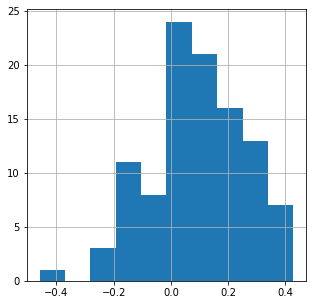

In [4]:
#load in covariates for grouping
covariates = pd.read_csv('data/Covariates_AllSubjects.csv')
covariates.head(15)

#grab only relevant columns
#could also grab control.insport and control.nc later
covariates = covariates[['conn.sub.num', 'cohort', 'mTBI', 'control.pooled', 'female', 'male', 'ses-1 fisher Z between BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala) and BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11)']]

#clean up a bit
covariates.head(15)
covariates.rename(inplace = True, columns = {'ses-1 fisher Z between BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala) and BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11)' : 'Ex ROI_Pair'})

#grab only patients which were present for T1
#covariates.info()
t1_covariates = covariates.dropna(inplace = False).copy()
#t1_covariates.info()

plt.rcParams['figure.figsize'] = 5,5
t1_covariates['Ex ROI_Pair'].hist()

#success!
#no longer need the ex ROI pair (just used to determine patients who did not complete their scan)
t1_covariates.drop(axis=1, inplace=True, labels = 'Ex ROI_Pair')
t1_covariates.reset_index(inplace=True, drop=True)

display(t1_covariates.head(10))
display(t1_covariates.tail(10))

Notably, even though I'm working with Fisher's Z Values, the example ROI pair I chose is not normally distributed/ centered around 0. Not important yet, but later it may be important that the dataset is notably imbalanced between TBI and non-TBI (fewer TBI). Will need to use some sort of oversampling/undersampling or utilize metrics which penalize classification errors across both groups treated as positive group. 

array([[<AxesSubplot:title={'center':'conn.sub.num'}>,
        <AxesSubplot:title={'center':'cohort'}>],
       [<AxesSubplot:title={'center':'mTBI'}>,
        <AxesSubplot:title={'center':'control.pooled'}>],
       [<AxesSubplot:title={'center':'female'}>,
        <AxesSubplot:title={'center':'male'}>]], dtype=object)

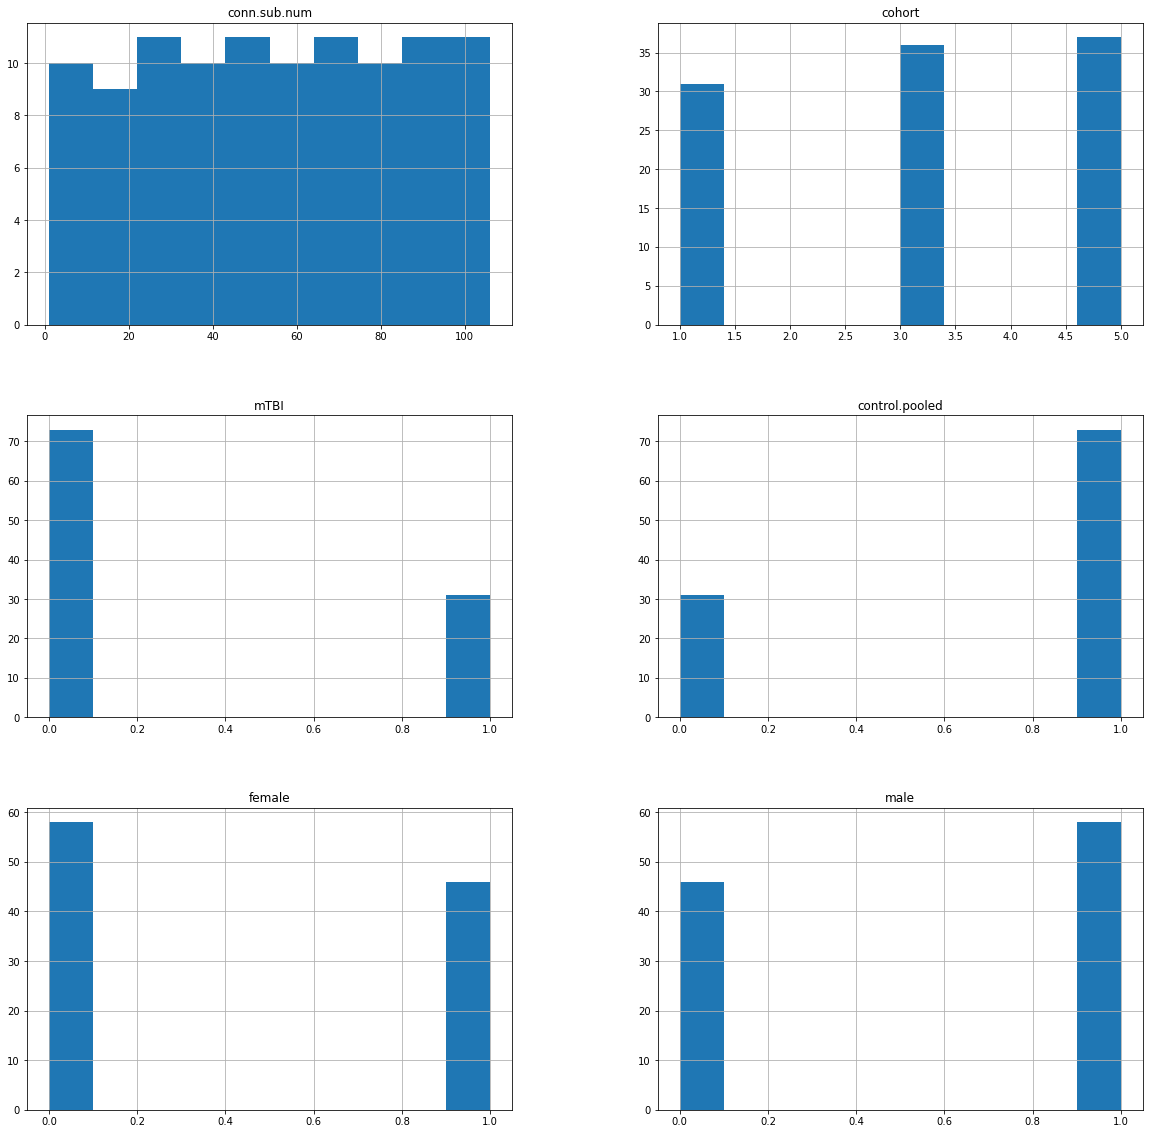

In [5]:
#make figure bigger
plt.rcParams['figure.figsize'] = 20,20

t1_covariates.hist()

In [6]:
ROIs.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ROIS'])

In [7]:
%load_ext autoreload
%autoreload 2

import sys
#print(sys.path)
#sys.path.append('/Users/danielfrees/Desktop/brainSPORT_Code/TBI_Graph_Proj/scripts/')
from graph_scripts.Load_Data import load_mats


In [8]:
mats = load_mats(data, ROIs)

Shape of passed ROI-ROI matrix data is: (270, 270, 104)
Number of ROI indices passed is: (1, 270)
All matrices filtered for '264' labeled atlas ROIs only. Shape of each participant matrix is (264, 264).


In [9]:
display(mats[0].head(10))

BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.517081         
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.424918         
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.267777         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                          -0.146196         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                          -0.066125         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.191596         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                           0.122094         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                          -0.060311         
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.013341         

                                                    BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.517081         
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.225464         
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.458162         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                          -0.210871         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                          -0.056273         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.083259         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                           0.149250         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                          -0.088856         
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.064346         

                                                    BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.424918          
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.225464          
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.000000          
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.183562          
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                          -0.165810          
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                           0.002523          
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.081704          
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                          -0.016103          
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                          -0.091708          
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.057501          

                                                    BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.267777          
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.458162          
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (

In [10]:
def zero_negatives(val):
    if val<=0:
        val=0
    return val

In [11]:
def process_negative_corrs(mats, method = 'zero'):
    if method == 'zero':
        for i in range(len(mats)):
            mats[i] = mats[i].applymap(zero_negatives)
    return mats
        

In [12]:
mats = process_negative_corrs(mats)
mats[0].head(15)

BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.517081         
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.424918         
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.267777         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.191596         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                           0.122094         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.013341         
BN_Atlas_264_2mm_wkbrois.L_SFG_A6dl (dorsolater...                                           0.146253         
BN_Atlas_264_2mm_wkbrois.R_SFG_A6dl (dorsolater...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A6m (medial area 6)                                           0.046253         
BN_Atlas_264_2mm_wkbrois.R_SFG_A6m (medial area 6)                                           0.171276         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9m (medial area 9)                                           0.000000         

                                                    BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.517081         
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.225464         
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.458162         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.083259         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                           0.149250         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.064346         
BN_Atlas_264_2mm_wkbrois.L_SFG_A6dl (dorsolater...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A6dl (dorsolater...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A6m (medial area 6)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A6m (medial area 6)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9m (medial area 9)                                           0.000000         

                                                    BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.424918          
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.225464          
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.000000          
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...

In [13]:
def pass_through_cutoff(val, cutoff):
    if val <= cutoff:
        val = 0
    return val

In [14]:
def dynamic_threshold(mat, percentile = 75):
    '''Dynamically threshold Fisher's Z values so that only the specified 
    percentile and up of correlation values are retained. This gives all graphs a density of 
    1-percentile.

    Expects a matrix with negative correlations already removed. Supported by current rsfMRI GT Literature.'''
    arr = mat.values
    cutoff = np.percentile(arr, 75)
    for col in mat.columns:
        mat[col] = mat[col].apply(pass_through_cutoff, args = [cutoff])
    return mat

In [15]:
def threshold_all_mats(mats, percentile):
    for i in range(len(mats)):
        mats[i] = dynamic_threshold(mats[i], percentile)
    return mats

In [16]:
mats = threshold_all_mats(mats, 75)

In [17]:
mats[0].head(10)

BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.517081         
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.424918         
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.267777         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.191596         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.000000         

                                                    BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.517081         
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.225464         
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.458162         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                           0.000000         
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                           0.149250         
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                           0.000000         
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.000000         

                                                    BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.424918          
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.225464          
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral ...                                           0.000000          
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral ...                                           0.183562          
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8)                                           0.000000          
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8)                                           0.000000          
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolater...                                           0.000000          
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolater...                                           0.000000          
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral are...                                           0.000000          
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral are...                                           0.000000          

                                                    BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala)  \
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial a...                                           0.267777          
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial a...                                           0.458162          
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (

In [18]:
def remove_atlas(str):
    str = str.replace('BN_Atlas_264_2mm_wkbrois.', '')
    return str

#Clean up ROI names
def clean_roi_names(mats):
    for i in range(len(mats)):
        mats[i] = mats[i].rename(remove_atlas, axis=1)
        mats[i] = mats[i].rename(remove_atlas, axis=0)
    return mats

In [19]:
mats = clean_roi_names(mats)
mats[0].head()

L_Amyg_mAmyg (medial amygdala)  \
L_Amyg_mAmyg (medial amygdala)                         0.000000   
R_Amyg_mAmyg (medial amygdala)                         0.517081   
L_Amyg_lAmyg (lateral amygdala)                        0.424918   
R_Amyg_lAmyg (lateral amygdala)                        0.267777   
L_SFG_A8m (medial area 8)                              0.000000   

                                 R_Amyg_mAmyg (medial amygdala)  \
L_Amyg_mAmyg (medial amygdala)                         0.517081   
R_Amyg_mAmyg (medial amygdala)                         0.000000   
L_Amyg_lAmyg (lateral amygdala)                        0.225464   
R_Amyg_lAmyg (lateral amygdala)                        0.458162   
L_SFG_A8m (medial area 8)                              0.000000   

                                 L_Amyg_lAmyg (lateral amygdala)  \
L_Amyg_mAmyg (medial amygdala)                          0.424918   
R_Amyg_mAmyg (medial amygdala)                          0.225464   
L_Amyg_lAmyg (lateral amygdala)                         0.000000   
R_Amyg_lAmyg (lateral amygdala)                         0.183562   
L_SFG_A8m (medial area 8)                               0.000000   

                                 R_Amyg_lAmyg (lateral amygdala)  \
L_Amyg_mAmyg (medial amygdala)                          0.267777   
R_Amyg_mAmyg (medial amygdala)                          0.458162   
L_Amyg_lAmyg (lateral amygdala)                         0.183562   
R_Amyg_lAmyg (lateral amygdala)                         0.000000   
L_SFG_A8m (medial area 8)                               0.000000   

                                 L_SFG_A8m (medial area 8)  \
L_Amyg_mAmyg (medial amygdala)                         0.0   
R_Amyg_mAmyg (medial amygdala)                         0.0   
L_Amyg_lAmyg (lateral amygdala)                        0.0   
R_Amyg_lAmyg (lateral amygdala)                        0.0   
L_SFG_A8m (medial area 8)                              0.0   

                                 R_SFG_A8m (medial area 8)  \
L_Amyg_mAmyg (medial amygdala)                    0.000000   
R_Amyg_mAmyg (medial amygdala)                    0.000000   
L_Amyg_lAmyg (lateral amygdala)                   0.000000   
R_Amyg_lAmyg (lateral amygdala)                   0.000000   
L_SFG_A8m (medial area 8)                         0.761407   

                                 L_SFG_A8dl (dorsolateral area 8)  \
L_Amyg_mAmyg (medial amygdala)                           0.191596   
R_Amyg_mAmyg (medial amygdala)                           0.000000   
L_Amyg_lAmyg (lateral amygdala)                          0.000000   
R_Amyg_lAmyg (lateral amygdala)                          0.220805   
L_SFG_A8m (medial area 8)                                0.000000   

                                 R_SFG_A8dl (dorsolateral area 8)  \
L_Amyg_mAmyg (medial amygdala)                            0.00000   
R_Amyg_mAmyg (medial amygdala)                            0.14925   
L_Amyg_lAmyg (lateral amygdala)                           0.00000   
R_Amyg_lAmyg (lateral amygdala)                           0.00000   
L_SFG_A8m (medial area 8)                                 0.00000   

                                 L_SFG_A9l (lateral area 9)  \
L_Amyg_mAmyg (medial amygdala)                     0.000000   
R_Amyg_mAmyg (medial amygdala)                     0.000000   
L_Amyg_lAmyg (lateral amygdala)                    0.000000   
R_Amyg_lAmyg (lateral amygdala)                    0.000000   
L_SFG_A8m (medial area 8)                          0.429212   

                                 R_SFG_A9l (lateral area 9)  \
L_Amyg_mAmyg (medial amygdala)                          0.0   
R_Amyg_mAmyg (medial amygdala)                          0.0   
L_Amyg_lAmyg (lateral amygdala)                         0.0   
R_Amyg_lAmyg (lateral amygdala)                         0.0   
L_SFG_A8m (medial area 8)                               0.0   

                                 L_SFG_A6dl (dorsolateral area 6)  \
L_Amyg

<a id = 'sub1'></a>
# Investigate Subject 1 In Detail & Design Graph Theoretical Augment Pipeline

Avg Clustering: 0.08309838360228661


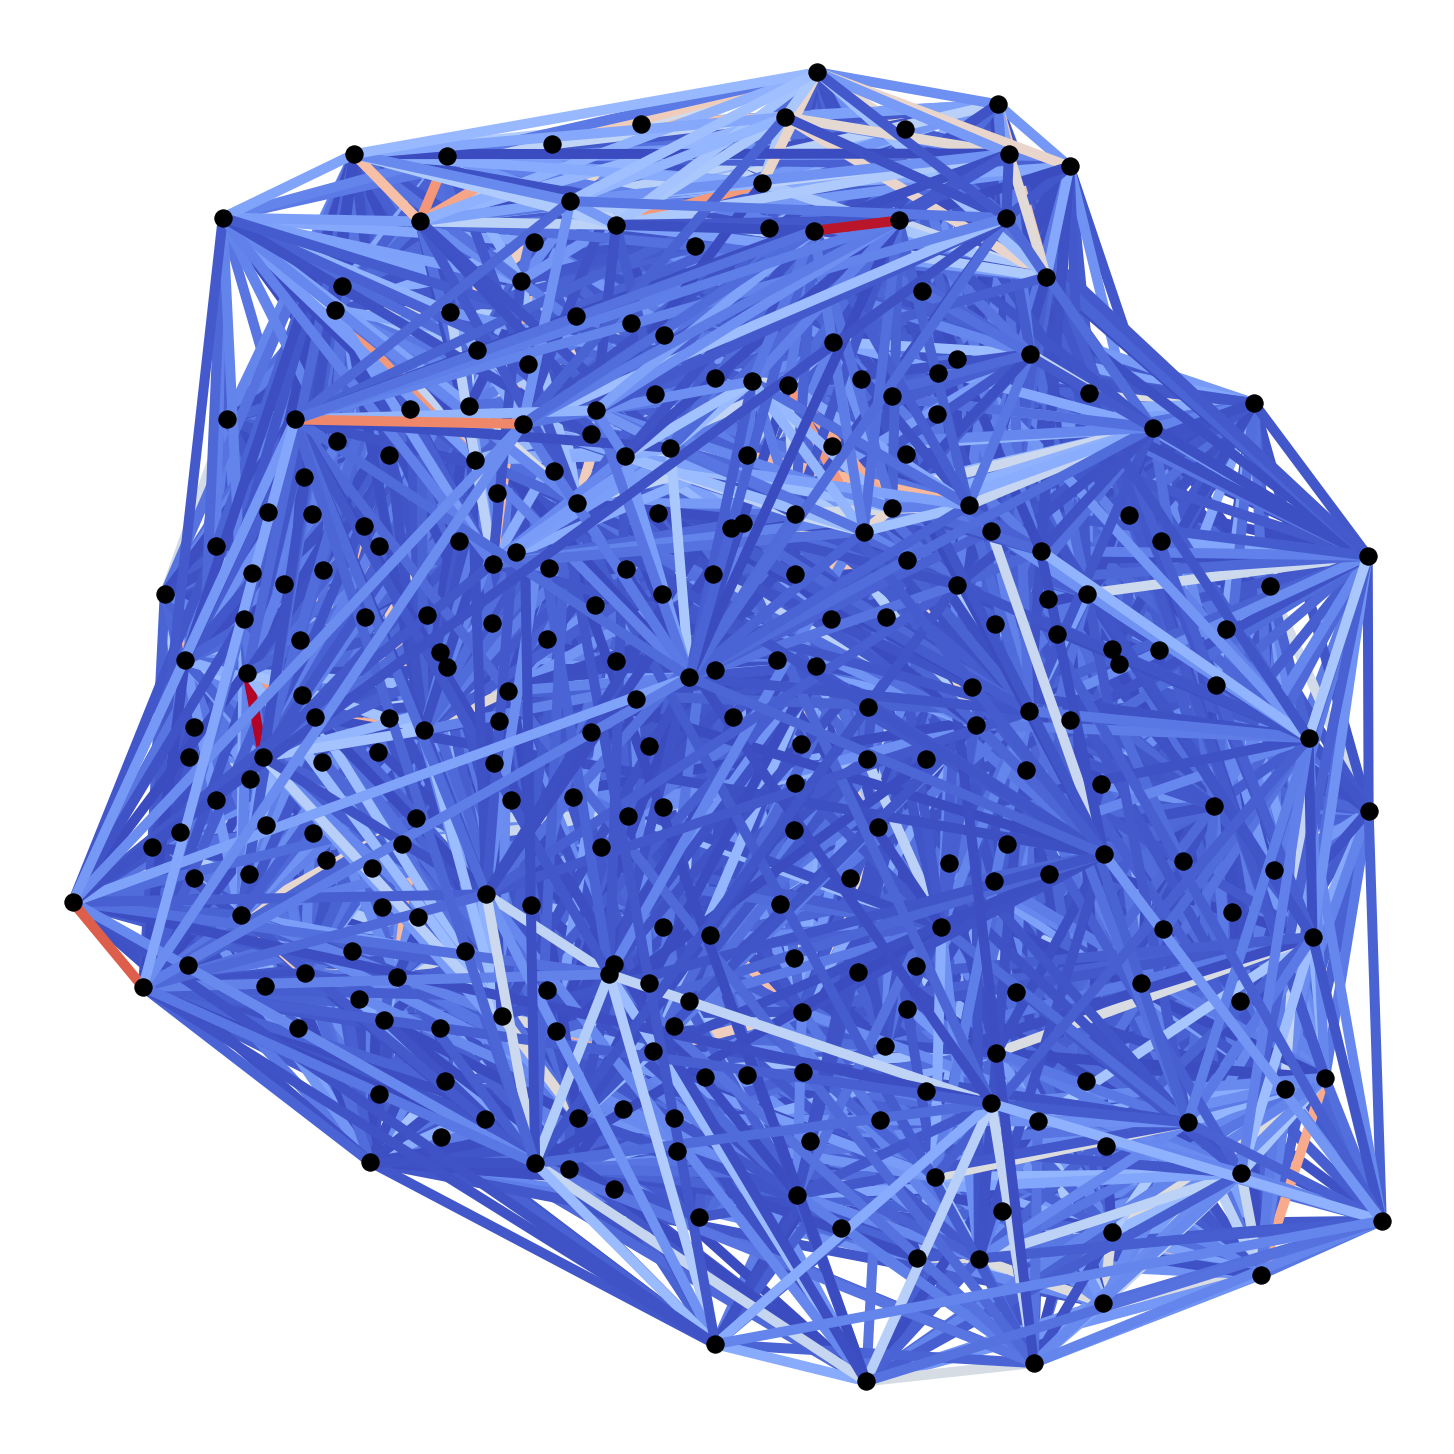

In [20]:
#Investigate participant 1 in detail

p1 = nx.from_pandas_adjacency(mats[0])
p1.name = 'participant_1'

edges,weights = zip(*nx.get_edge_attributes(p1,'weight').items())
pos = nx.spring_layout(p1)
nx.draw(p1, pos, node_color='black', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.coolwarm)

print("Avg Clustering: " + str(nx.average_clustering(p1, weight = 'weight')))



In [21]:
#unhash to see node names (they match the ROIs given)
#p1.nodes

In [22]:
#TODO: Not working at the moment + Too computationally expensive

#from networkx, I modified for weighted shortest paths -> weighted global efficiency
def global_efficiency(G):
    """Returns the average global efficiency of the graph.

    The *efficiency* of a pair of nodes in a graph is the multiplicative
    inverse of the shortest path distance between the nodes. The *average
    global efficiency* of a graph is the average efficiency of all pairs of
    nodes [1]_.

    """
    n = len(G)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_shortest_path_length(G, weight = 'weight')
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if distance > 0:
                    g_eff += 1 / distance
        g_eff /= denom
        # g_eff = sum(1 / d for s, tgts in lengths
        #                   for t, d in tgts.items() if d > 0) / denom
    else:
        g_eff = 0
    # TODO This can be made more efficient by computing all pairs shortest
    # path lengths in parallel.
    return g_eff


In [23]:
#TODO: need to figure out how do these weighted
#print("Avg Local Efficiency: " + str(nx.local_efficiency(p1, weight = 'weight')))
#print("Avg Global Efficiency: " + str(global_efficiency(p1)))

In [24]:
nodes_of_interest = []
for node in p1.nodes:
    if 'Amy' in node:
        print(node)
        nodes_of_interest.append(node)
        

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


In [25]:
#Investigate Amygdala Nodes (Nodal Degree)
p1.degree(nbunch = nodes_of_interest)

DegreeView({'L_Amyg_mAmyg (medial amygdala)': 60, 'R_Amyg_mAmyg (medial amygdala)': 55, 'L_Amyg_lAmyg (lateral amygdala)': 58, 'R_Amyg_lAmyg (lateral amygdala)': 46, 'L_dAmy': 71, 'R_dAmy': 60, 'L_mAmy': 65, 'R_mAmy': 58, 'L_vlAmy': 67, 'R_vlAmy': 63})

In [26]:
nodes_of_interest

['L_Amyg_mAmyg (medial amygdala)',
 'R_Amyg_mAmyg (medial amygdala)',
 'L_Amyg_lAmyg (lateral amygdala)',
 'R_Amyg_lAmyg (lateral amygdala)',
 'L_dAmy',
 'R_dAmy',
 'L_mAmy',
 'R_mAmy',
 'L_vlAmy',
 'R_vlAmy']

In [27]:
#Investigate Amygdala Nodes (Nodal Strength)

p1.degree(weight = 'weight', nbunch = nodes_of_interest)

DegreeView({'L_Amyg_mAmyg (medial amygdala)': 16.764669885551925, 'R_Amyg_mAmyg (medial amygdala)': 15.172976223788561, 'L_Amyg_lAmyg (lateral amygdala)': 15.480157515848322, 'R_Amyg_lAmyg (lateral amygdala)': 13.011417882513465, 'L_dAmy': 21.693333945135155, 'R_dAmy': 20.24736649080644, 'L_mAmy': 19.10259923408086, 'R_mAmy': 18.79674146002364, 'L_vlAmy': 19.814593215529705, 'R_vlAmy': 20.261907212813913})

In [28]:
#Investigate shortest unweighted path between Amygdala Nodes and 

this_to_LMB = nx.shortest_path_length(p1,'L_dAmy', 'L_MB')
this_to_RMB = nx.shortest_path_length(p1,'L_dAmy', 'R_MB')
print(this_to_LMB)
print(this_to_RMB)

2
2


In [29]:
len(mats)

104

In [30]:
#Covariates correct for this time point

len(t1_covariates)

104

In [31]:
#Look at type of Covariate this Mat Corresponds to 
cov = t1_covariates.loc[0,:]
cov

conn.sub.num      1
cohort            1
mTBI              1
control.pooled    0
female            0
male              1
Name: 0, dtype: int64

In [32]:
#Characteristic Path Length of graph (average unweighted shortest path length )
#This may become more interesting with some thresholding

UW_CPL = nx.average_shortest_path_length(p1)
UW_CPL

1.7627318815531743

In [33]:
#density for all graphs should be 25% roughly (and the exact same for each) if dynamic density thresholding is working
nx.density(p1)

0.2509505703422053

In [34]:
p2 = nx.from_pandas_adjacency(mats[1])

In [35]:
nx.density(p2)

0.2509505703422053

In [36]:
#looks good so far

In [37]:
#Closeness Centrality
amy_ccs = {}
for n in nodes_of_interest:
    print(n)
    amy_ccs[n] = nx.closeness_centrality(p1, n)
amy_ccs

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


{'L_Amyg_mAmyg (medial amygdala)': 0.5607675906183369,
 'R_Amyg_mAmyg (medial amygdala)': 0.5525210084033614,
 'L_Amyg_lAmyg (lateral amygdala)': 0.5607675906183369,
 'R_Amyg_lAmyg (lateral amygdala)': 0.5411522633744856,
 'L_dAmy': 0.578021978021978,
 'R_dAmy': 0.5595744680851064,
 'L_mAmy': 0.5692640692640693,
 'R_mAmy': 0.5583864118895966,
 'L_vlAmy': 0.5729847494553377,
 'R_vlAmy': 0.5643776824034334}

In [38]:
#TRANSITIVITY 
nx.transitivity(p1)

0.4581542338942458

### TODO: Need to Discuss With Kevin About how to Parse the ROIs into networks and find network modularity

In [39]:
#MODULARITY 


In [40]:
#insert any graph and get node of interest which should work for all graphs (same ROIs)
def get_nodes_of_interest(graph):
    nodes_of_interest = []
    for node in graph.nodes:
        if 'Amy' in node:
            print(node)
            nodes_of_interest.append(node)
    return nodes_of_interest

In [41]:
nodes_of_interest = get_nodes_of_interest(p1)

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


## Complete Pipeline For Subject 1

In [42]:
#PRIOR TO THIS:
#1. Each Subject has ROI-same ROI correlations zeroed
#2. Negative correlations zeroed
#3. Adjacency matrix of correlation values thresholding to generate graphs of 25% density for all participants

#INIT SUBJECT
subject = pd.Series(dtype = 'int64')

#GRAB COVARIATES
cov = t1_covariates.loc[0,:]
display(cov)

subject['Subject_Number'] = cov['conn.sub.num']
subject['mTBI'] = cov['mTBI']
subject['Male'] = cov['male']

#subject

#GENERATE GRAPH FOR THIS SUBJECT
g = nx.from_pandas_adjacency(mats[0])
g.name = f'subj_{1}'

#unhash if you want to display patient graph:
#edges, weights = zip(*nx.get_edge_attributes(g,'weight').items())
#pos = nx.spring_layout(p1)
#nx.draw(p1, pos, node_color='black', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.coolwarm)

#CLUSTERING COEFFICIENTS
subject['Avg_Clustering (W)'] = nx.average_clustering(g, weight = 'weight')
subject['Avg_Clustering (UW)'] = nx.average_clustering(g)

#INVESTIGATE CHARACTERISTIC PATH LENGTH FOR G
UW_CPL = nx.average_shortest_path_length(g)

subject['Characteristic_Path_Length'] = UW_CPL

#INVESTIGATE DENSITY (Should be the same for all graphs!! ~1-percentile chosen for dynamic thresholding)
subject['Density'] = nx.density(g)

#INVESTIGATE TRANSITIVITY 
subject['Transitivity'] = nx.transitivity(g)


#NODES OF INTEREST-----------------------------------------------------------------------------------------------
#NODAL DEGREE FOR NODES OF INTEREST
#Investigate Amygdala Nodes Currently (Nodal Degree)
degree_view = g.degree(nbunch = nodes_of_interest)
nodes = (node for (node, val) in degree_view)
for node in nodes:
    subject[f"Node_Degree--{node}"] = degree_view[node]


#NODAL STRENGTH FOR NODES OF INTEREST
degree_view = g.degree(nbunch = nodes_of_interest, weight = 'weight')
nodes = (node for (node, val) in degree_view)
for node in nodes:
    subject[f"Node_Strength--{node}"] = degree_view[node]
    

#CALCULATE CLOSENESS CENTRALITIES FOR NODES OF INTEREST
dict_ccs = {}
for n in nodes_of_interest:
    dict_ccs[n] = nx.closeness_centrality(g, n)
    subject[f"Closeness_Centrality--{n}"] = nx.closeness_centrality(g, n)

    
#INVESTIGATE SHORTEST PATHS BETWEEN THESE PAIRS OF NODES
pair_1 = ['L_dAmy', 'L_MB']
pair_2 = ['L_dAmy', 'R_MB']

SP_pair1 = nx.shortest_path_length(g,pair_1[0],pair_1[1])
SP_pair2 = nx.shortest_path_length(g,pair_2[0],pair_2[1])

subject[f'Shortest_Path--{pair_1[0]}&{pair_1[1]}'] = SP_pair1
subject[f'Shortest_Path--{pair_2[0]}&{pair_2[1]}'] = SP_pair2


#-----------------------------------------------------------------------------------------------------------------

#CONVERT TO INT DATATYPE WHERE APPROPRIATE AND MAKE INTO DF

subject = pd.DataFrame(subject).transpose()

int_data_dict = {'Subject_Number': 'int32', 
                 'mTBI': 'int32', 
                 'Male': 'int32', 
                 'Node_Degree--L_Amyg_mAmyg (medial amygdala)':'int32', 
                 'Node_Degree--R_Amyg_mAmyg (medial amygdala)':'int32', 
                 'Node_Degree--L_Amyg_lAmyg (lateral amygdala)':'int32', 
                 'Node_Degree--R_Amyg_lAmyg (lateral amygdala)':'int32', 
                 'Node_Degree--L_dAmy':'int32', 
                 'Node_Degree--R_dAmy':'int32', 
                 'Node_Degree--L_mAmy':'int32', 
                 'Node_Degree--R_mAmy':'int32', 
                 'Node_Degree--L_vlAmy':'int32', 
                 'Node_Degree--R_vlAmy': 'int32',
                 'Shortest_Path--L_dAmy&L_MB':'int32',           
                 'Shortest_Path--L_dAmy&R_MB': 'int32'}

subject = subject.astype(int_data_dict)
display(subject.head())
display(subject.info())

conn.sub.num      1
cohort            1
mTBI              1
control.pooled    0
female            0
male              1
Name: 0, dtype: int64

Subject_Number  mTBI  Male  Avg_Clustering (W)  Avg_Clustering (UW)  \
0               1     1     1            0.083098             0.452872   

   Characteristic_Path_Length   Density  Transitivity  \
0                    1.762732  0.250951      0.458154   

   Node_Degree--L_Amyg_mAmyg (medial amygdala)  \
0                                           60   

   Node_Degree--R_Amyg_mAmyg (medial amygdala)  \
0                                           55   

   Node_Degree--L_Amyg_lAmyg (lateral amygdala)  \
0                                            58   

   Node_Degree--R_Amyg_lAmyg (lateral amygdala)  Node_Degree--L_dAmy  \
0                                            46                   71   

   Node_Degree--R_dAmy  Node_Degree--L_mAmy  Node_Degree--R_mAmy  \
0                   60                   65                   58   

   Node_Degree--L_vlAmy  Node_Degree--R_vlAmy  \
0                    67                    63   

   Node_Strength--L_Amyg_mAmyg (medial amygdala)  \
0                                       16.76467   

   Node_Strength--R_Amyg_mAmyg (medial amygdala)  \
0                                      15.172976   

   Node_Strength--L_Amyg_lAmyg (lateral amygdala)  \
0                                       15.480158   

   Node_Strength--R_Amyg_lAmyg (lateral amygdala)  Node_Strength--L_dAmy  \
0                                       13.011418              21.693334   

   Node_Strength--R_dAmy  Node_Strength--L_mAmy  Node_Strength--R_mAmy  \
0              20.247366              19.102599              18.796741   

   Node_Strength--L_vlAmy  Node_Strength--R_vlAmy  \
0               19.814593               20.261907   

   Closeness_Centrality--L_Amyg_mAmyg (medial amygdala)  \
0                                           0.560768      

   Closeness_Centrality--R_Amyg_mAmyg (medial amygdala)  \
0                                           0.552521      

   Closeness_Centrality--L_Amyg_lAmyg (lateral amygdala)  \
0                                           0.560768       

   Closeness_Centrality--R_Amyg_lAmyg (lateral amygdala)  \
0                                           0.541152       

   Closeness_Centrality--L_dAmy  Closeness_Centrality--R_dAmy  \
0                      0.578022                      0.559574   

   Closeness_Centrality--L_mAmy  Closeness_Centrality--R_mAmy  \
0                      0.569264                      0.558386   

   Closeness_Centrality--L_vlAmy  Closeness_Centrality--R_vlAmy  \
0                       0.572985                       0.564378   

   Shortest_Path--L_dAmy&L_MB  Shortest_Path--L_dAmy&R_MB  
0                           2                           2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Subject_Number                                         1 non-null      int32  
 1   mTBI                                                   1 non-null      int32  
 2   Male                                                   1 non-null      int32  
 3   Avg_Clustering (W)                                     1 non-null      float64
 4   Avg_Clustering (UW)                                    1 non-null      float64
 5   Characteristic_Path_Length                             1 non-null      float64
 6   Density                                                1 non-null      float64
 7   Transitivity                                           1 non-null      float64
 8   Node_Degree--L_Amyg_mAmyg (medial amygdala)           

None

<a id='graphpipe'></a>
# Graph Theory Measure Pipeline for All Participants

## Graph Theory Pipeline Func for each Subject

In [43]:
def generate_data_for_subject(mats, t1_covariates, nodes_of_interest, subject_number):  
    '''Generates Graph Theory Data for a given subject.

    Expects list of weighted adjacency matrices for all subjects, 
    covariates matrix/array of same length as # of subjects, 
    nodes of interest for certain metrics, 
    subject number to calculate for.

    Outputs a dataframe with all graph theory data for this subject'''
    #INIT SUBJECT
    subject = pd.Series(dtype = 'int64')

    #GRAB COVARIATES
    cov = t1_covariates.loc[subject_number,:]

    subject['Subject_Number'] = cov['conn.sub.num']
    subject['mTBI'] = cov['mTBI']
    subject['Male'] = cov['male']

    #subject

    #GENERATE GRAPH FOR THIS SUBJECT
    g = nx.from_pandas_adjacency(mats[subject_number])
    g.name = f'subj_{1}'

    #unhash if you want to display patient graph:
    #edges, weights = zip(*nx.get_edge_attributes(g,'weight').items())
    #pos = nx.spring_layout(p1)
    #nx.draw(p1, pos, node_color='black', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.coolwarm)

    #CLUSTERING COEFFICIENTS
    subject['Avg_Clustering (W)'] = nx.average_clustering(g, weight = 'weight')
    subject['Avg_Clustering (UW)'] = nx.average_clustering(g)

    #INVESTIGATE CHARACTERISTIC PATH LENGTH FOR G
    UW_CPL = nx.average_shortest_path_length(g)

    subject['Characteristic_Path_Length'] = UW_CPL

    #INVESTIGATE DENSITY (Should be the same for all graphs!! ~1-percentile chosen for dynamic thresholding)
    subject['Density'] = nx.density(g)

    #INVESTIGATE TRANSITIVITY 
    subject['Transitivity'] = nx.transitivity(g)


    #NODES OF INTEREST-----------------------------------------------------------------------------------------------
    #NODAL DEGREE FOR NODES OF INTEREST
    #Investigate Amygdala Nodes Currently (Nodal Degree)
    degree_view = g.degree(nbunch = nodes_of_interest)
    nodes = (node for (node, val) in degree_view)
    for node in nodes:
        subject[f"Node_Degree--{node}"] = degree_view[node]


    #NODAL STRENGTH FOR NODES OF INTEREST
    degree_view = g.degree(nbunch = nodes_of_interest, weight = 'weight')
    nodes = (node for (node, val) in degree_view)
    for node in nodes:
        subject[f"Node_Strength--{node}"] = degree_view[node]


    #CALCULATE CLOSENESS CENTRALITIES FOR NODES OF INTEREST
    dict_ccs = {}
    for n in nodes_of_interest:
        dict_ccs[n] = nx.closeness_centrality(g, n)
        subject[f"Closeness_Centrality--{n}"] = nx.closeness_centrality(g, n)


    #INVESTIGATE SHORTEST PATHS BETWEEN THESE PAIRS OF NODES
    pair_1 = ['L_dAmy', 'L_MB']
    pair_2 = ['L_dAmy', 'R_MB']

    SP_pair1 = nx.shortest_path_length(g,pair_1[0],pair_1[1])
    SP_pair2 = nx.shortest_path_length(g,pair_2[0],pair_2[1])

    subject[f'Shortest_Path--{pair_1[0]}&{pair_1[1]}'] = SP_pair1
    subject[f'Shortest_Path--{pair_2[0]}&{pair_2[1]}'] = SP_pair2


    #-----------------------------------------------------------------------------------------------------------------

    #CONVERT TO INT DATATYPE WHERE APPROPRIATE AND MAKE INTO DF

    subject = pd.DataFrame(subject).transpose()

    int_data_dict = {'Subject_Number': 'int32', 
                     'mTBI': 'int32', 
                     'Male': 'int32', 
                     'Node_Degree--L_Amyg_mAmyg (medial amygdala)':'int32', 
                     'Node_Degree--R_Amyg_mAmyg (medial amygdala)':'int32', 
                     'Node_Degree--L_Amyg_lAmyg (lateral amygdala)':'int32', 
                     'Node_Degree--R_Amyg_lAmyg (lateral amygdala)':'int32', 
                     'Node_Degree--L_dAmy':'int32', 
                     'Node_Degree--R_dAmy':'int32', 
                     'Node_Degree--L_mAmy':'int32', 
                     'Node_Degree--R_mAmy':'int32', 
                     'Node_Degree--L_vlAmy':'int32', 
                     'Node_Degree--R_vlAmy': 'int32',
                     'Shortest_Path--L_dAmy&L_MB':'int32',           
                     'Shortest_Path--L_dAmy&R_MB': 'int32'}

    subject = subject.astype(int_data_dict)
    
    return subject

<a id = 'combine'></a>
## Iterate Over All Subjects, Combine

In [44]:
nodes_of_interest = get_nodes_of_interest(p1)  #arbitrary subject choice, same nodes of interest for everyone, just need to be extracted

all_data = []
for subject_number in range(len(mats)):
    all_data.append(generate_data_for_subject(mats, t1_covariates, nodes_of_interest, subject_number))
    
all_data = pd.concat(all_data, axis = 0)
all_data.reset_index(inplace = True, drop=True)

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


In [45]:
all_data.head(104)

Subject_Number  mTBI  Male  Avg_Clustering (W)  Avg_Clustering (UW)  \
0                 1     1     1            0.083098             0.452872   
1                 2     1     1            0.092424             0.460006   
2                 3     1     1            0.082997             0.500558   
3                 4     1     1            0.073645             0.453328   
4                 5     1     1            0.090309             0.476002   
5                 6     1     1            0.087578             0.475884   
6                 7     1     1            0.065934             0.485933   
7                 9     1     1            0.098178             0.496253   
8                10     1     1            0.080202             0.466429   
9                11     1     1            0.085747             0.466183   
10               12     1     1            0.085325             0.450980   
11               13     1     1            0.103656             0.503418   
12               14     1     1            0.078887             0.463851   
13               15     1     1            0.083301             0.480333   
14               17     1     1            0.087637             0.468751   
15               18     1     1            0.076323             0.477104   
16               19     1     1            0.075991             0.458277   
17               20     1     0            0.068571             0.470405   
18               21     1     0            0.069307             0.466712   
19               22     1     0            0.076071             0.521539   
20               23     1     0            0.083665             0.488733   
21               24     1     0            0.083333             0.494208   
22               25     1     0            0.087516             0.493973   
23               26     1     0            0.081345             0.469796   
24               27     1     0            0.077998             0.498605   
25               28     1     0            0.075069             0.489845   
26               29     1     0            0.087184             0.470774   
27               30     1     0            0.075913             0.446005   
28               31     1     0            0.082521             0.465302   
29               32     1     0            0.074378             0.462442   
30               33     1     0            0.068174             0.474870   
31               34     0     1            0.091183             0.534008   
32               35     0     1            0.077683             0.509446   
33               36     0     1            0.098906             0.508846   
34               37     0     1            0.091204             0.484602   
35               38     0     1            0.084809             0.476782   
36               39     0     1            0.092322             0.494668   
37               40     0     1            0.072669             0.455369   
38               41     0     1            0.068812             0.462152   
39               42     0     1            0.078967             0.473283   
40               43     0     1            0.090394             0.508403   
41               44     0     1            0.087618             0.476306   
42               45     0     1            0.099949             0.504098   
43               46     0     1            0.084408             0.474963   
44               47     0     1            0.058431             0.463895   
45               48     0     1            0.084686             0.505550   
46               49     0     1            0.094557             0.477249   
47               50     0     1            0.092267             0.497001   
48               51     0     1            0.078333             0.470700   
49               52     0     1            0.079867             0.458783   
50               53     0     0            0.089963             0.483531   
51               54     0     0            0.070850  

<a id = 'graph_hist'></a>
# All Subjects Graph Data Plotted

array([[<AxesSubplot:title={'center':'Subject_Number'}>,
        <AxesSubplot:title={'center':'mTBI'}>,
        <AxesSubplot:title={'center':'Male'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (W)'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (UW)'}>,
        <AxesSubplot:title={'center':'Characteristic_Path_Length'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Transitivity'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_lAmyg (lateral amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_lAmyg (lateral amygdala)'}>],
       [<AxesSubplot:title={'center':'Node_Degree--L_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_mAmy'}>,
        <AxesSubpl

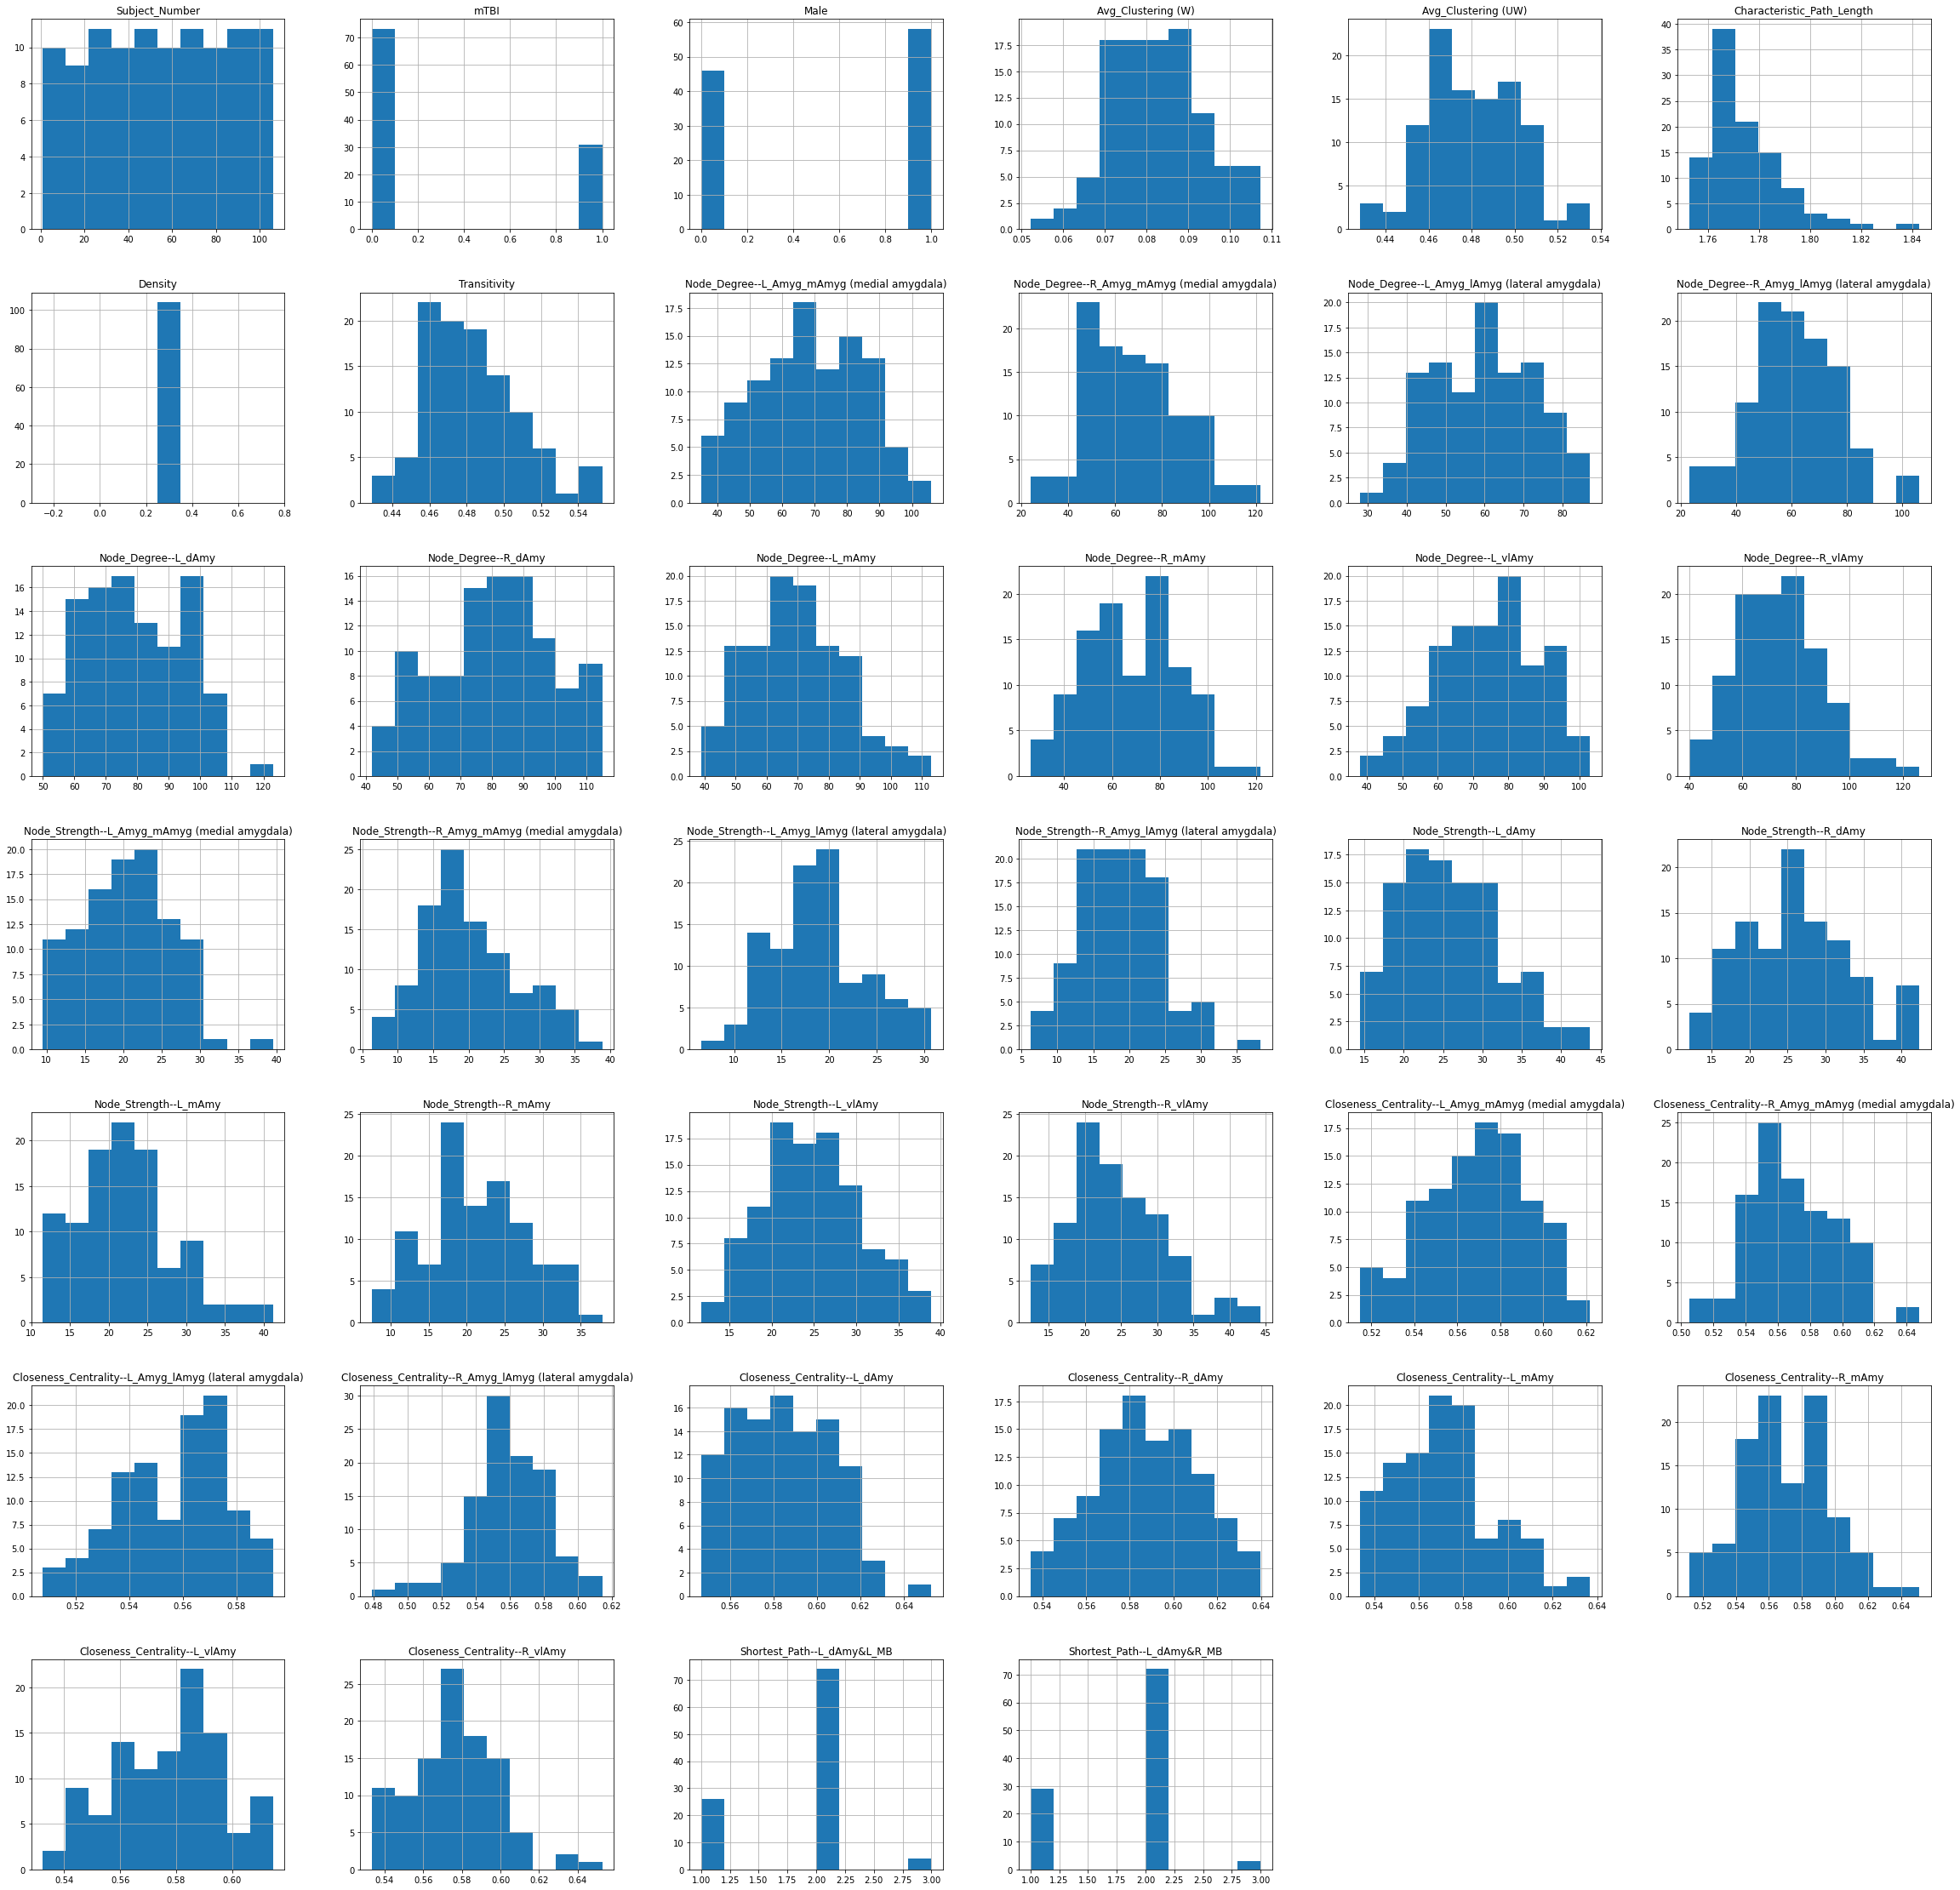

In [46]:
#make figure bigger
plt.rcParams['figure.figsize'] = 40, 40
all_data.hist(bins = 10)

In [47]:
tbi_data = all_data[all_data['mTBI']==1]

In [48]:
hc_data = all_data[all_data['mTBI']==0]

array([[<AxesSubplot:title={'center':'Subject_Number'}>,
        <AxesSubplot:title={'center':'mTBI'}>,
        <AxesSubplot:title={'center':'Male'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (W)'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (UW)'}>,
        <AxesSubplot:title={'center':'Characteristic_Path_Length'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Transitivity'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_lAmyg (lateral amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_lAmyg (lateral amygdala)'}>],
       [<AxesSubplot:title={'center':'Node_Degree--L_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_mAmy'}>,
        <AxesSubpl

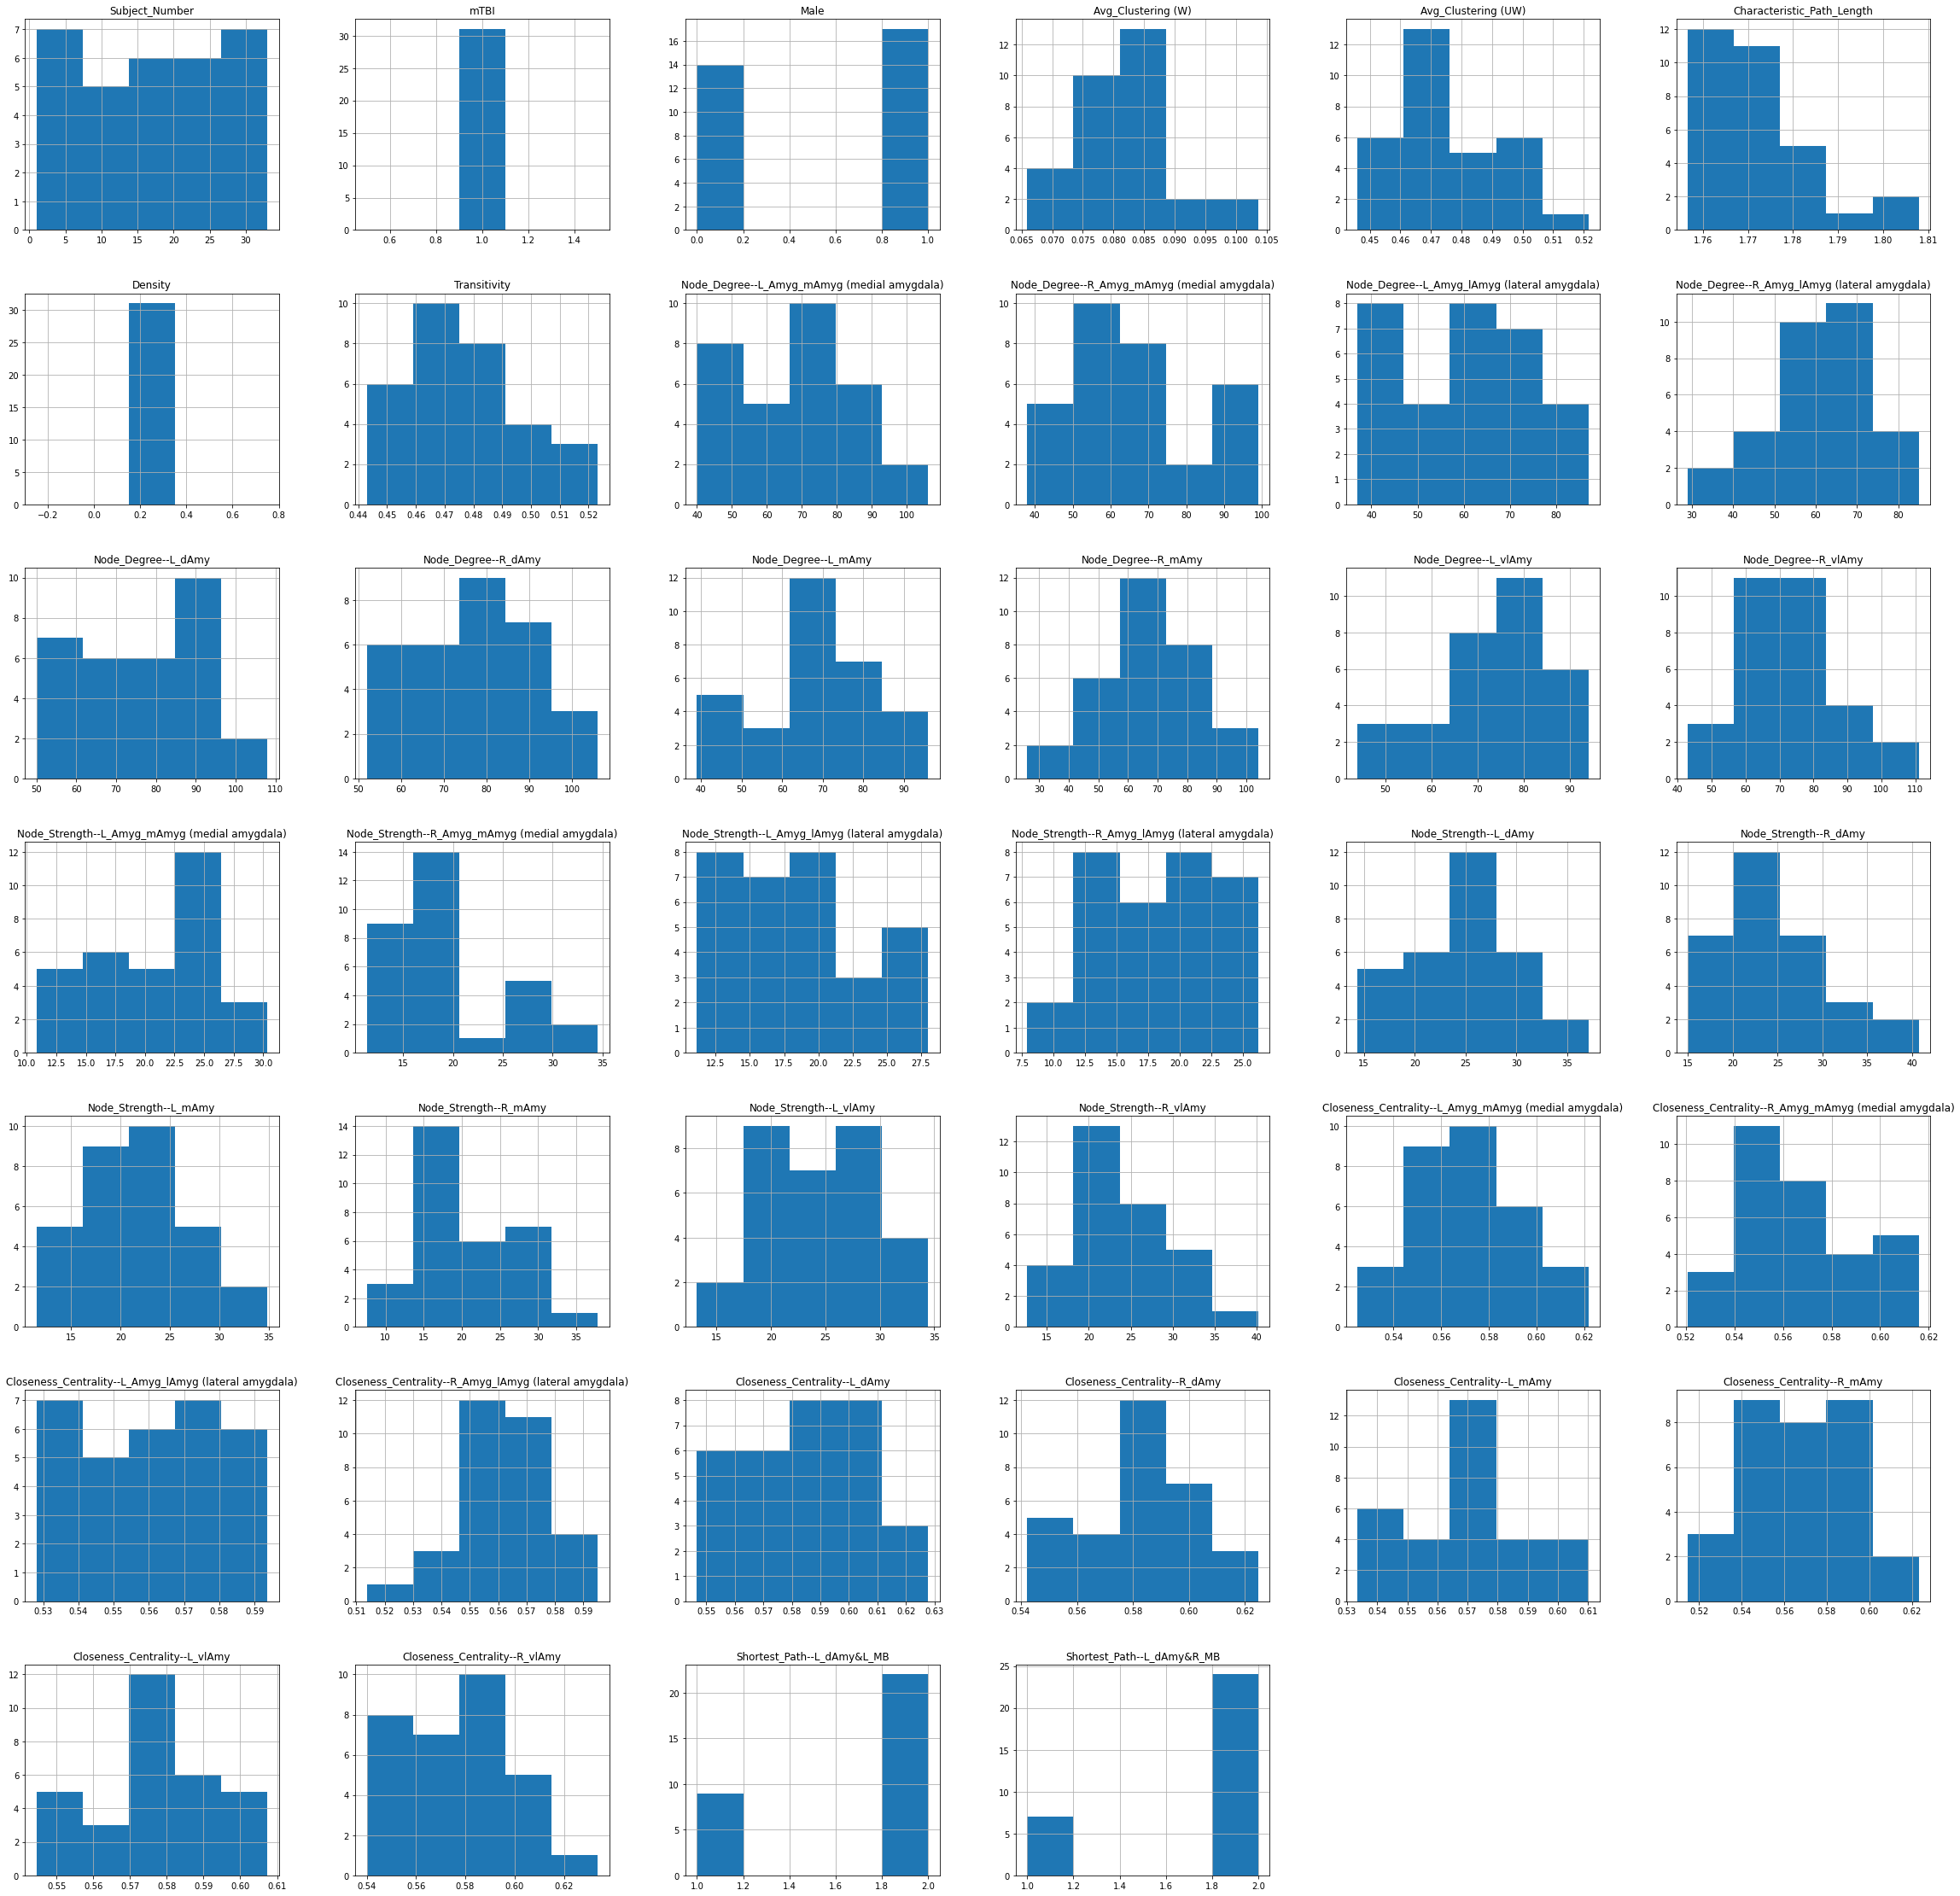

In [49]:
tbi_data
tbi_data.hist(bins=5)

array([[<AxesSubplot:title={'center':'Subject_Number'}>,
        <AxesSubplot:title={'center':'mTBI'}>,
        <AxesSubplot:title={'center':'Male'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (W)'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (UW)'}>,
        <AxesSubplot:title={'center':'Characteristic_Path_Length'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Transitivity'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_lAmyg (lateral amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_lAmyg (lateral amygdala)'}>],
       [<AxesSubplot:title={'center':'Node_Degree--L_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_mAmy'}>,
        <AxesSubpl

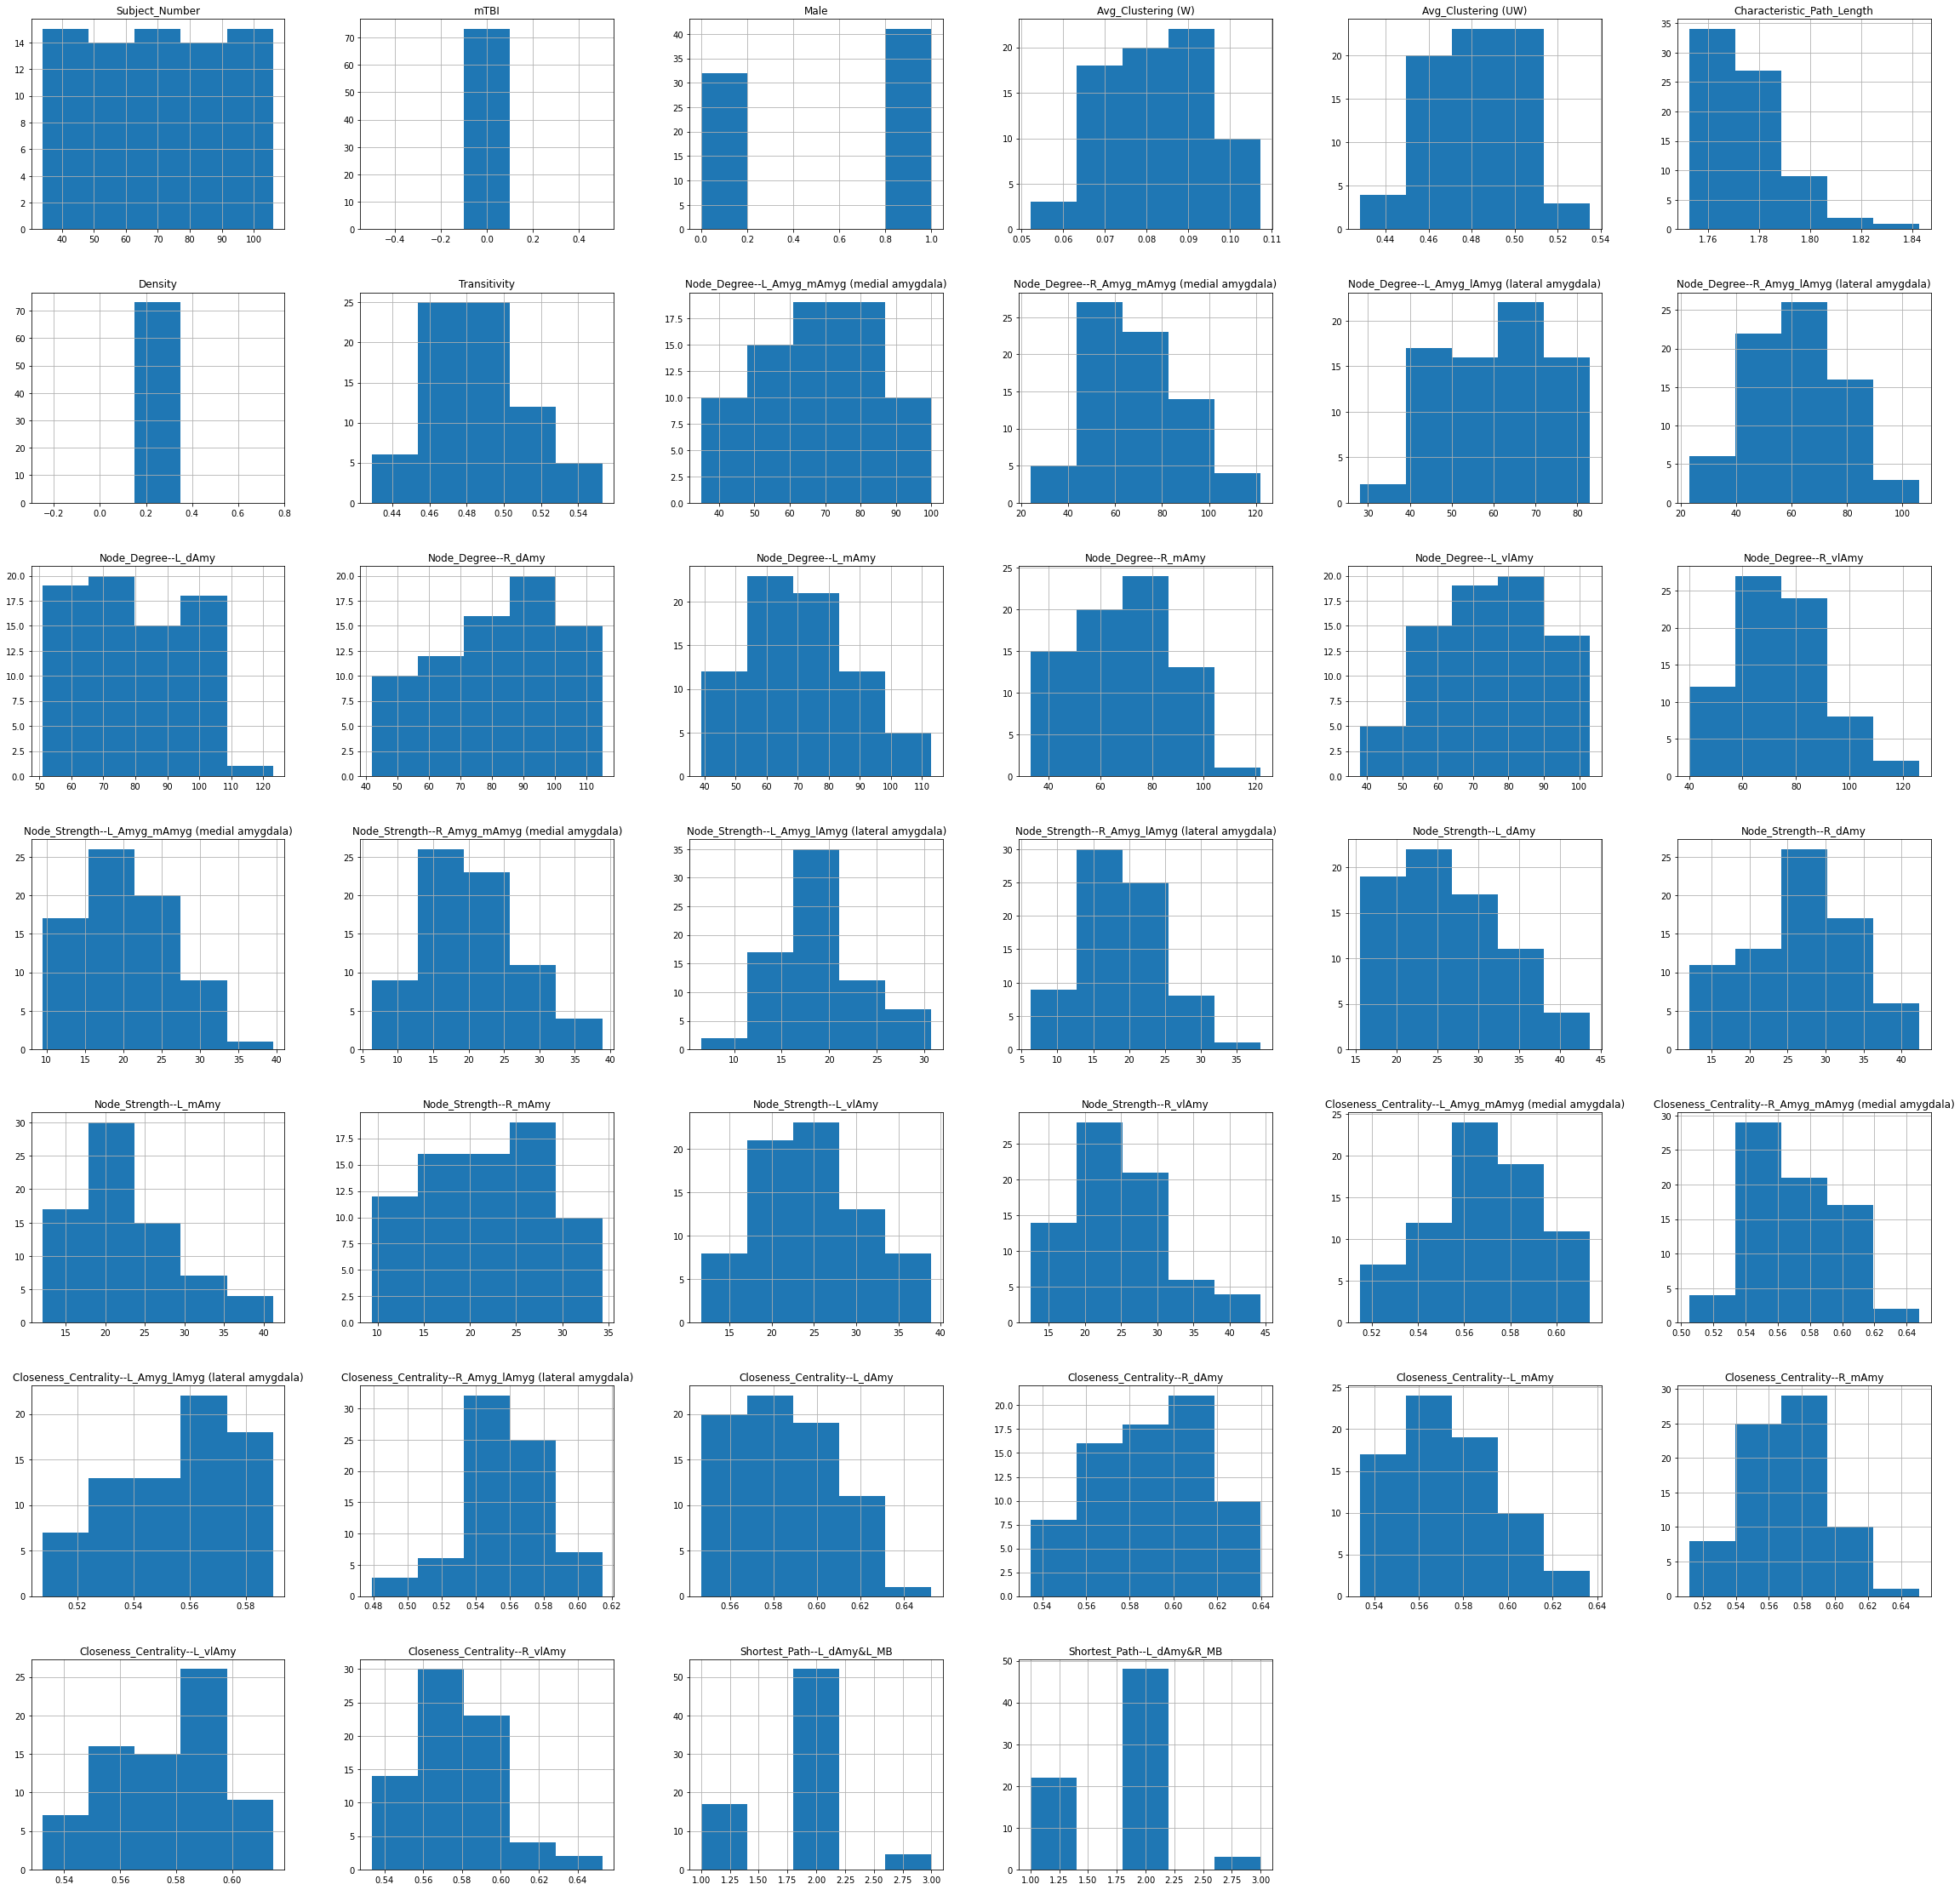

In [50]:
hc_data
hc_data.hist(bins = 5)

For both the TBI and Healthy Control Groups, not all distributions are normal. But they are close enough that we will approximate them as normal for the sake of t-testing. 

<a id='results'></a>

# RESULTS

In [51]:
tbi_results = {}

for column in tbi_data.columns:
    tbi_results[f"Mean: {column}"] = np.mean(tbi_data[column])
    tbi_results[f"Stdev: {column}"] = np.std(tbi_data[column])

tbi_results

{'Mean: Subject_Number': 17.322580645161292,
 'Stdev: Subject_Number': 9.683331527387814,
 'Mean: mTBI': 1.0,
 'Stdev: mTBI': 0.0,
 'Mean: Male': 0.5483870967741935,
 'Stdev: Male': 0.49765318130779057,
 'Mean: Avg_Clustering (W)': 0.08136375140262249,
 'Stdev: Avg_Clustering (W)': 0.008398136750138273,
 'Mean: Avg_Clustering (UW)': 0.4757862708564099,
 'Stdev: Avg_Clustering (UW)': 0.017497380884895528,
 'Mean: Characteristic_Path_Length': 1.7718640470694933,
 'Stdev: Characteristic_Path_Length': 0.011288611419374373,
 'Mean: Density': 0.2509505703422052,
 'Stdev: Density': 1.1102230246251565e-16,
 'Mean: Transitivity': 0.477041858443963,
 'Stdev: Transitivity': 0.01944025052455944,
 'Mean: Node_Degree--L_Amyg_mAmyg (medial amygdala)': 68.96774193548387,
 'Stdev: Node_Degree--L_Amyg_mAmyg (medial amygdala)': 15.716200540120177,
 'Mean: Node_Degree--R_Amyg_mAmyg (medial amygdala)': 66.38709677419355,
 'Stdev: Node_Degree--R_Amyg_mAmyg (medial amygdala)': 16.54061944339691,
 'Mean: Node

In [52]:
hc_results = {}

for column in hc_data.columns:
    hc_results[f"Mean: {column}"] = np.mean(hc_data[column])
    hc_results[f"Stdev: {column}"] = np.std(hc_data[column])

hc_results

{'Mean: Subject_Number': 70.0,
 'Stdev: Subject_Number': 21.071307505705477,
 'Mean: mTBI': 0.0,
 'Stdev: mTBI': 0.0,
 'Mean: Male': 0.5616438356164384,
 'Stdev: Male': 0.49618548702122794,
 'Mean: Avg_Clustering (W)': 0.08300923736326025,
 'Stdev: Avg_Clustering (W)': 0.011451076464692402,
 'Mean: Avg_Clustering (UW)': 0.48201102519428246,
 'Stdev: Avg_Clustering (UW)': 0.022053166223119,
 'Mean: Characteristic_Path_Length': 1.7758571705912714,
 'Stdev: Characteristic_Path_Length': 0.01530819513489394,
 'Mean: Density': 0.25095057034220514,
 'Stdev: Density': 1.6653345369377348e-16,
 'Mean: Transitivity': 0.4856682203791674,
 'Stdev: Transitivity': 0.02710534855037159,
 'Mean: Node_Degree--L_Amyg_mAmyg (medial amygdala)': 68.05479452054794,
 'Stdev: Node_Degree--L_Amyg_mAmyg (medial amygdala)': 16.598308554656597,
 'Mean: Node_Degree--R_Amyg_mAmyg (medial amygdala)': 67.8082191780822,
 'Stdev: Node_Degree--R_Amyg_mAmyg (medial amygdala)': 20.584378658921885,
 'Mean: Node_Degree--L_Amy

## 2-Sample T-Testing

In [53]:
from scipy import stats

In [54]:
t_test = {}

for column in all_data.columns:
    t_test[column] = stats.ttest_ind(a=tbi_data[column], b=hc_data[column], equal_var = False, alternative = 'two-sided', random_state=42)
    
t_test

{'Subject_Number': Ttest_indResult(statistic=-17.2808264286182, pvalue=5.986806924323372e-32),
 'mTBI': Ttest_indResult(statistic=inf, pvalue=0.0),
 'Male': Ttest_indResult(statistic=-0.12269113739683758, pvalue=0.902790968933791),
 'Avg_Clustering (W)': Ttest_indResult(statistic=-0.8055886373164196, pvalue=0.42300723225553505),
 'Avg_Clustering (UW)': Ttest_indResult(statistic=-1.5115026398416567, pvalue=0.13515773813738535),
 'Characteristic_Path_Length': Ttest_indResult(statistic=-1.4578403640058208, pvalue=0.14904869549713226),
 'Density': Ttest_indResult(statistic=-5.47722557505166, pvalue=6.055176384095931e-06),
 'Transitivity': Ttest_indResult(statistic=-1.8065289139992298, pvalue=0.07473347380281045),
 'Node_Degree--L_Amyg_mAmyg (medial amygdala)': Ttest_indResult(statistic=0.2628916386478209, pvalue=0.793549185140252),
 'Node_Degree--R_Amyg_mAmyg (medial amygdala)': Ttest_indResult(statistic=-0.36687487921323386, pvalue=0.7148317848842727),
 'Node_Degree--L_Amyg_lAmyg (lateral

In [55]:
for (key, value) in t_test.items():
    if value.pvalue < 0.1:
        print(f"Significant Group Difference: {key}")
        print(f"p-val: {value}")
        print()

Significant Group Difference: Subject_Number
p-val: Ttest_indResult(statistic=-17.2808264286182, pvalue=5.986806924323372e-32)

Significant Group Difference: mTBI
p-val: Ttest_indResult(statistic=inf, pvalue=0.0)

Significant Group Difference: Density
p-val: Ttest_indResult(statistic=-5.47722557505166, pvalue=6.055176384095931e-06)

Significant Group Difference: Transitivity
p-val: Ttest_indResult(statistic=-1.8065289139992298, pvalue=0.07473347380281045)



## Results Interpretation

Significant results with an $\alpha=0.1$ threshold are found across Subject_number, mTBI, Density, and Transitivity. 

Subject_Number is significant only because subject numbers were ordered from TBI to HC. -> Doesn't indicate anything.

mTBI is significant because it is the way the groups were formed. -> Doesn't indicate anything.

Density is significant only because of minor differences in node thresholding (tied nodes can ever so slighlty affect my manually chosen %25 density conformity requirement imposed in the dynamic thresholding function). There is no difference between groups, but the standard deviation of density is so low that we get a very low p-value.

**Transitivity** on the other hand, is an interesting group difference finding. While the p-value would only be semi-significant at $\alpha=0.05$, this is still a potentially important finding. 

Transitivity is a measure which can be interpreted in terms of cliqueiness of a graph, whereby higher transitivity indicates that node relationships are more likely to form a clique. Specifically, transitivity measures the chance that if node $x$ knows node $y$ (is correlated), and $y$ is correlated with $z$, then $x$ is also correlated with $z$. 

Based on this data, transitivity seems to be higher for the healthy control group ($\mu=0.4857$) than the traumatic brain injury group ($\mu=0.47704$), indicating that perhaps traumatic brain injury breaks down cliques. 

<AxesSubplot:>

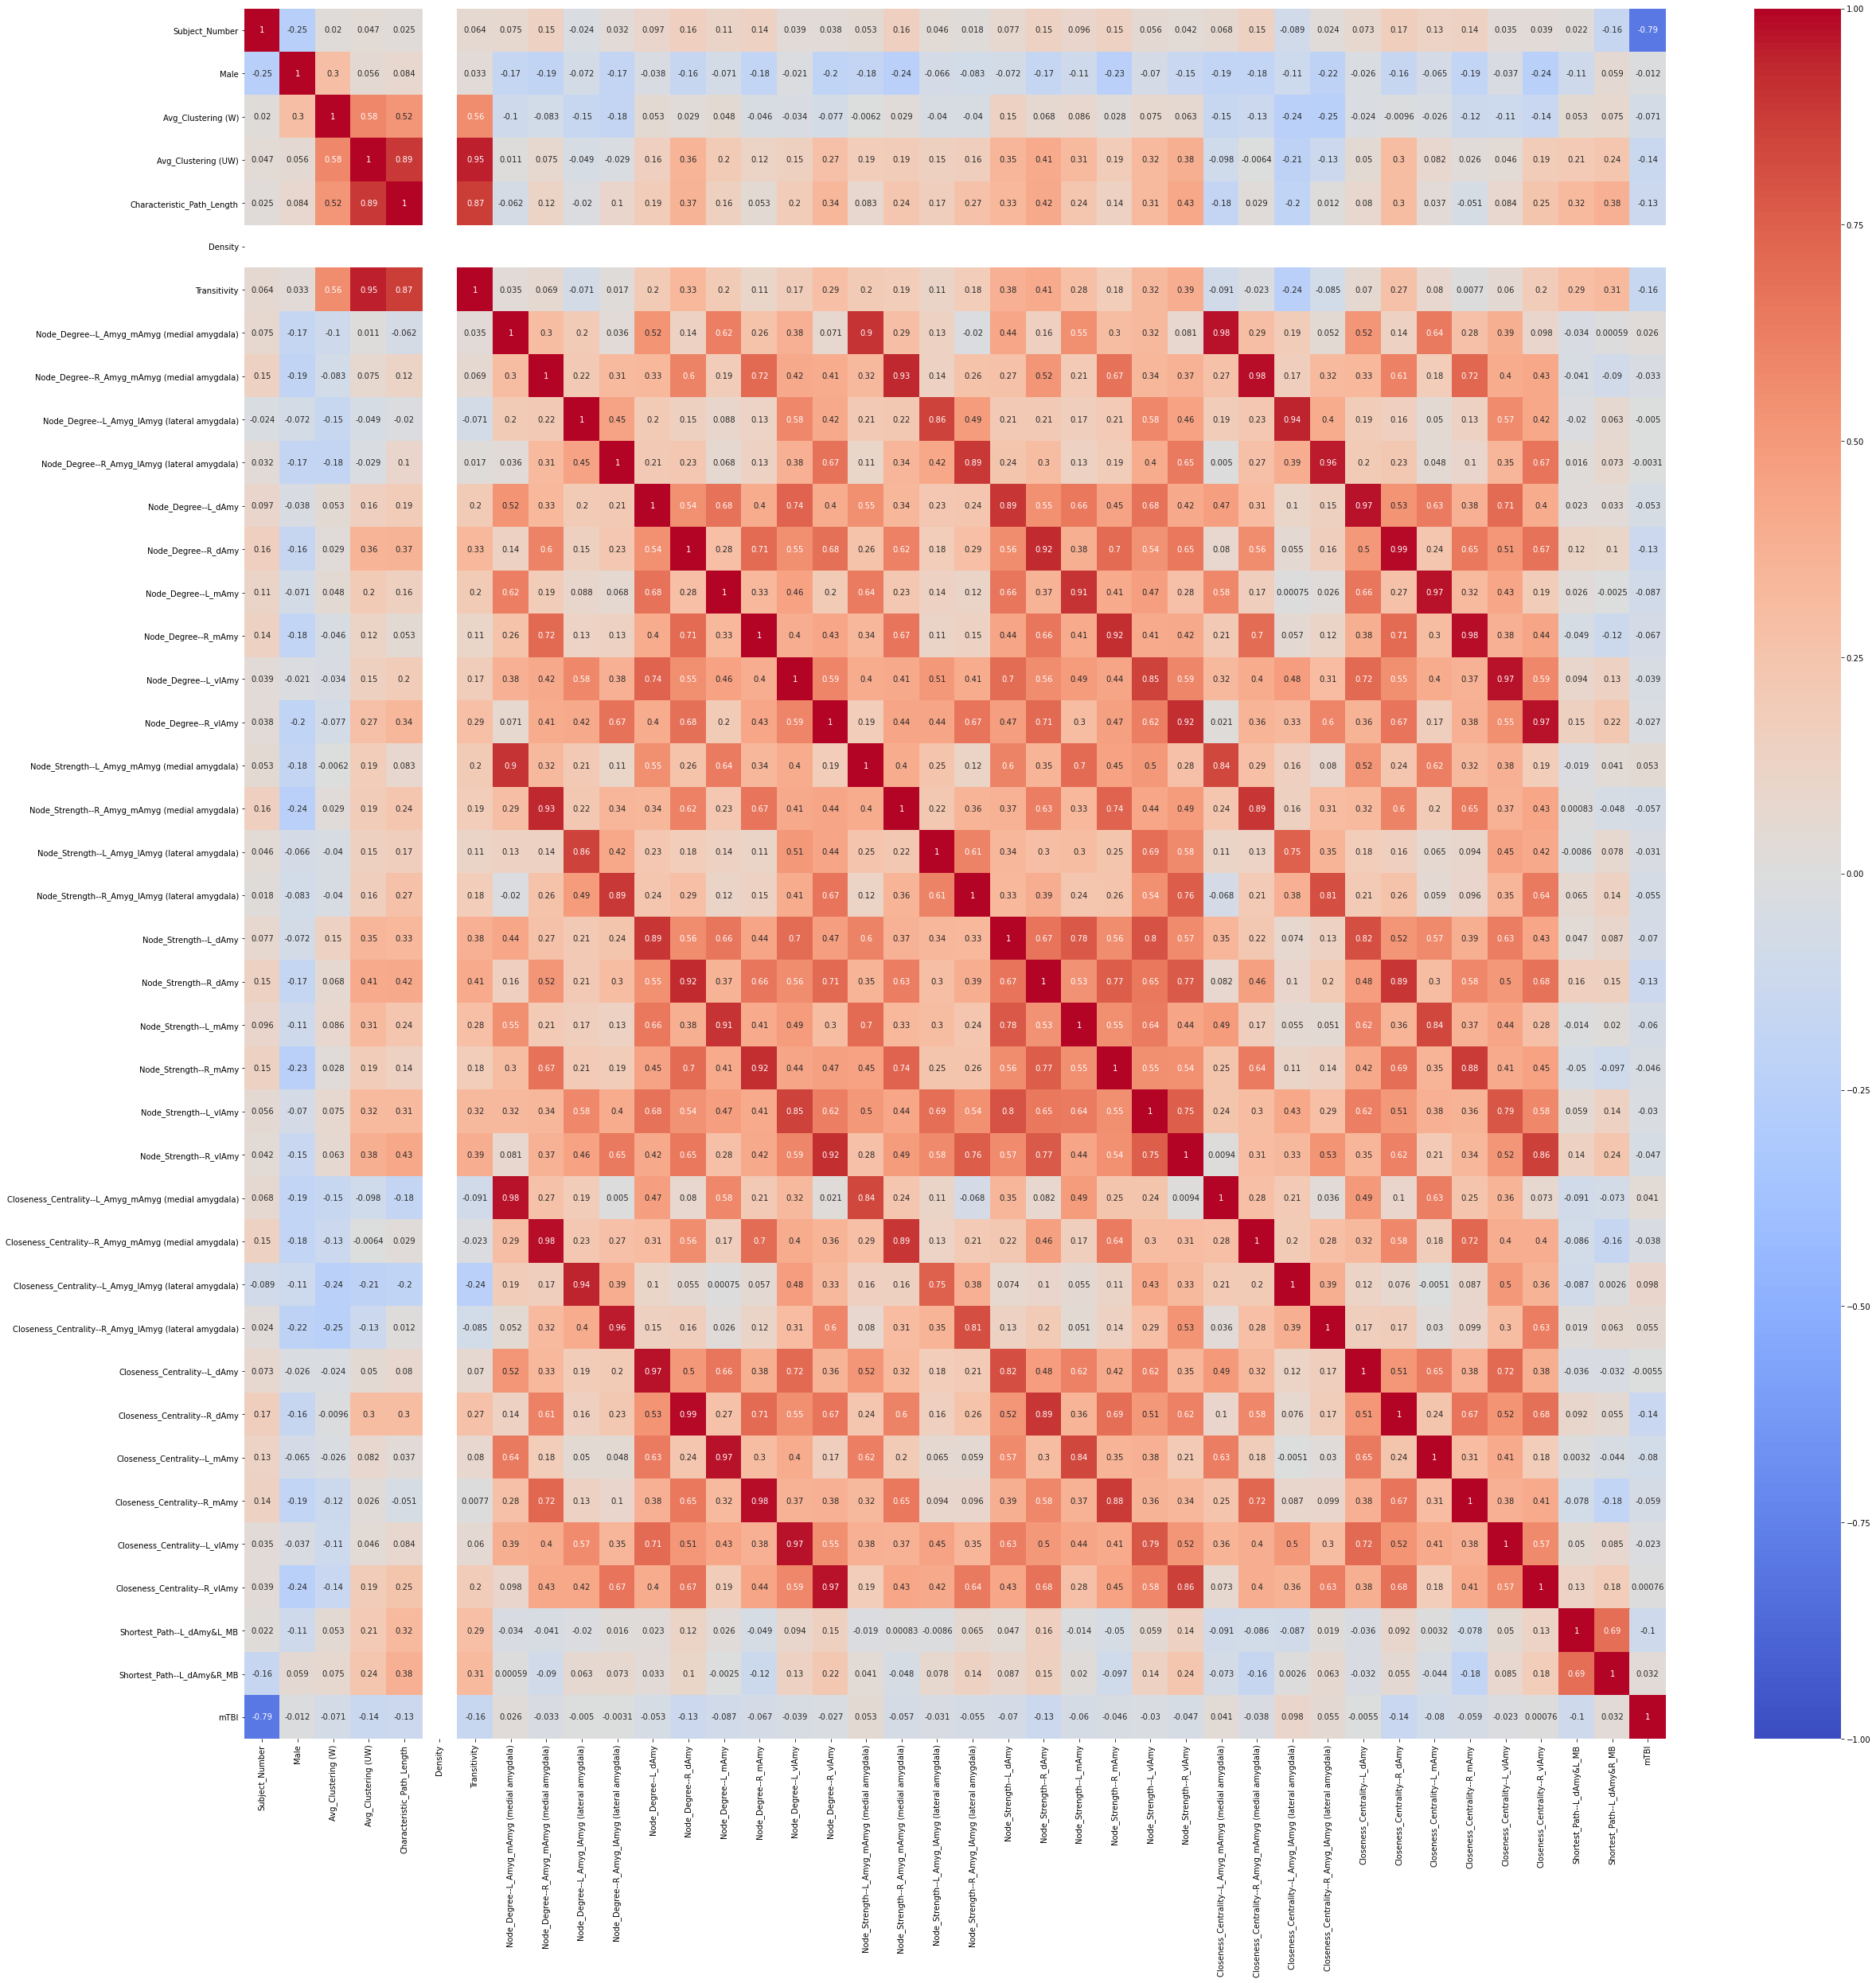

In [56]:
import seaborn as sns

#reorder so correlations with TBI are more apparent
cols = all_data.columns.to_list()
cols.append(cols[1])
del(cols[1])
cols
all_data_vis = all_data[cols]
sns.heatmap(all_data_vis.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)


## Correlation Analysis

mTBI is moderately negatively correlated with average unweighted clustering coefficient, characteristic path length, transitivity, both node degree and node strength for the right dorsal amygdala ROI, closeness centrality for the right dorsal amygdala ROI, and shortest path length between the left dorsal amygdala and left MB.

Furthermore, mTBI is moderately positive correlated with closeness centrality of the left lateral amygdala. 

<a id= 'ML_expl'></a>

# Machine Learning Exploration

In [57]:
all_data.head()

Subject_Number  mTBI  Male  Avg_Clustering (W)  Avg_Clustering (UW)  \
0               1     1     1            0.083098             0.452872   
1               2     1     1            0.092424             0.460006   
2               3     1     1            0.082997             0.500558   
3               4     1     1            0.073645             0.453328   
4               5     1     1            0.090309             0.476002   

   Characteristic_Path_Length   Density  Transitivity  \
0                    1.762732  0.250951      0.458154   
1                    1.764662  0.250951      0.454151   
2                    1.798479  0.250951      0.505704   
3                    1.762703  0.250951      0.456221   
4                    1.769127  0.250951      0.479131   

   Node_Degree--L_Amyg_mAmyg (medial amygdala)  \
0                                           60   
1                                           53   
2                                           74   
3                                           50   
4                                           71   

   Node_Degree--R_Amyg_mAmyg (medial amygdala)  \
0                                           55   
1                                           50   
2                                           46   
3                                           75   
4                                           55   

   Node_Degree--L_Amyg_lAmyg (lateral amygdala)  \
0                                            58   
1                                            46   
2                                            77   
3                                            69   
4                                            53   

   Node_Degree--R_Amyg_lAmyg (lateral amygdala)  Node_Degree--L_dAmy  \
0                                            46                   71   
1                                            65                   60   
2                                            64                   87   
3                                            85                   70   
4                                            52                   78   

   Node_Degree--R_dAmy  Node_Degree--L_mAmy  Node_Degree--R_mAmy  \
0                   60                   65                   58   
1                   80                   39                   42   
2                   70                   55                   54   
3                   85                   53                   84   
4                   52                   63                   51   

   Node_Degree--L_vlAmy  Node_Degree--R_vlAmy  \
0                    67                    63   
1                    54                    60   
2                    80                    87   
3                    85                    92   
4                    64                    47   

   Node_Strength--L_Amyg_mAmyg (medial amygdala)  \
0                                      16.764670   
1                                      17.494817   
2                                      24.296358   
3                                      12.583102   
4                                      20.475743   

   Node_Strength--R_Amyg_mAmyg (medial amygdala)  \
0                                      15.172976   
1                                      18.624630   
2                                      12.497805   
3                                      19.435541   
4                                      17.703841   

   Node_Strength--L_Amyg_lAmyg (lateral amygdala)  \
0                                       15.480158   
1                                       13.132975   
2                                       27.751380   
3                                       19.396630   
4                                       17.363405   

   Node_Strength--R_Amyg_lAmyg (lateral amygdala)  Node_Strength--L_dAmy  \
0                                       13.011418              21.693334   
1                                       21.876253              18.454146

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
#Separate features from target (whether a patient has mTBI or not)
features = all_data.drop('mTBI', axis=1, inplace=False)
target = all_data['mTBI']

## Simple KNN Model

In [60]:
#drop subject_number because this will be a strong predictor only because it was designed relative to whether a patient had mTBI (data leaking)
features = features.drop('Subject_Number', axis=1)

In [61]:
features.head()

Male  Avg_Clustering (W)  Avg_Clustering (UW)  Characteristic_Path_Length  \
0     1            0.083098             0.452872                    1.762732   
1     1            0.092424             0.460006                    1.764662   
2     1            0.082997             0.500558                    1.798479   
3     1            0.073645             0.453328                    1.762703   
4     1            0.090309             0.476002                    1.769127   

    Density  Transitivity  Node_Degree--L_Amyg_mAmyg (medial amygdala)  \
0  0.250951      0.458154                                           60   
1  0.250951      0.454151                                           53   
2  0.250951      0.505704                                           74   
3  0.250951      0.456221                                           50   
4  0.250951      0.479131                                           71   

   Node_Degree--R_Amyg_mAmyg (medial amygdala)  \
0                                           55   
1                                           50   
2                                           46   
3                                           75   
4                                           55   

   Node_Degree--L_Amyg_lAmyg (lateral amygdala)  \
0                                            58   
1                                            46   
2                                            77   
3                                            69   
4                                            53   

   Node_Degree--R_Amyg_lAmyg (lateral amygdala)  Node_Degree--L_dAmy  \
0                                            46                   71   
1                                            65                   60   
2                                            64                   87   
3                                            85                   70   
4                                            52                   78   

   Node_Degree--R_dAmy  Node_Degree--L_mAmy  Node_Degree--R_mAmy  \
0                   60                   65                   58   
1                   80                   39                   42   
2                   70                   55                   54   
3                   85                   53                   84   
4                   52                   63                   51   

   Node_Degree--L_vlAmy  Node_Degree--R_vlAmy  \
0                    67                    63   
1                    54                    60   
2                    80                    87   
3                    85                    92   
4                    64                    47   

   Node_Strength--L_Amyg_mAmyg (medial amygdala)  \
0                                      16.764670   
1                                      17.494817   
2                                      24.296358   
3                                      12.583102   
4                                      20.475743   

   Node_Strength--R_Amyg_mAmyg (medial amygdala)  \
0                                      15.172976   
1                                      18.624630   
2                                      12.497805   
3                                      19.435541   
4                                      17.703841   

   Node_Strength--L_Amyg_lAmyg (lateral amygdala)  \
0                                       15.480158   
1                                       13.132975   
2                                       27.751380   
3                                       19.396630   
4                                       17.363405   

   Node_Strength--R_Amyg_lAmyg (lateral amygdala)  Node_Strength--L_dAmy  \
0                                       13.011418              21.693334   
1                                       21.876253              18.454146   
2                                       22.380927              31.476304   
3                                       23.602914              19.745431   
4      

In [62]:
#normalize data so that KNN model can be used properly (sens. to differently scaled features)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features = ss.fit_transform(features)
features

array([[ 0.89056356,  0.05437526, -1.29957867, ..., -0.5577441 ,
         0.42849916,  0.50487816],
       [ 0.89056356,  0.92918318, -0.95978997, ..., -0.93692424,
         0.42849916,  0.50487816],
       [ 0.89056356,  0.04490572,  0.97181201, ...,  0.89473572,
         0.42849916,  0.50487816],
       ...,
       [-1.12288448, -0.55998243, -0.35906897, ..., -1.04320872,
         0.42849916, -1.51463449],
       [-1.12288448, -1.33418642, -2.47428249, ..., -0.66723873,
         0.42849916,  0.50487816],
       [-1.12288448, -0.90443867, -0.8137851 , ...,  0.11948262,
        -1.59713324, -1.51463449]])

In [63]:
#split data into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 0)

In [64]:
#test out Kneighbors model

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [65]:
preds = knn.predict(X_test)

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(preds, y_test)

0.5

In [67]:
#Ok, so that's pretty bad.. lets try a different value for number of neighbors

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 20), 
          'weights': ['uniform', 'distance']
         }
clf = GridSearchCV(estimator = knn, param_grid = params, error_score = 'raise')
clf.fit(X_train, y_train)

best_knn = clf.best_estimator_

#clf.cv_results_

In [70]:
preds = best_knn.predict(X_test)
accuracy_score(preds, y_test)

0.53125

<b>Conclusion on Basic KNN Model</b>

The basic KNN model seems to be a very poor predictor for the data, worse than simply predicting majority class. I'm guessing the issue is that there are a ton of features, many of which aren't going to prove to be important, yet KNN has to assume all features its given are equally important (equally because I normalized the features before input). 

Perhaps KNN will be worth coming back to after some kind of feature selection/reduction such as PCA. 

For now, this is a very poor model. 

## Basic Decision Tree Model

In [71]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
dt = DecisionTreeClassifier(random_state=42)

In [73]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [74]:
accuracy_score(dt.predict(X_test), y_test)

0.53125

In [75]:
len(all_data[all_data['mTBI']==1])

31

In [76]:
len(all_data)

104

In [77]:
majority_class_len = max(len(all_data)-len(all_data[all_data['mTBI']==1]), len(all_data[all_data['mTBI']==1]))
majority_class_len

73

In [78]:
naive_accuracy = majority_class_len/len(all_data)
print(f"Expecting a naive accuracy of {naive_accuracy}")

Expecting a naive accuracy of 0.7019230769230769


In [79]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 30, 2),
          'max_features': ['sqrt', 'log2']
    
}
clf = GridSearchCV(estimator = dt, param_grid = params)

In [80]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30, 2),
                         'max_features': ['sqrt', 'log2']})

In [81]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=1, max_features='sqrt', random_state=42)

In [82]:
best_dt = clf.best_estimator_

In [83]:
accuracy_score(best_dt.predict(X_test), y_test)

0.65625

In [84]:
best_dt.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

<b>Final Thoughts on simple Decision Tree Classifier</b>

Another poor estimator. Better than KNN but not even better than the naive accuracy rate of ~0.7 that I should be hitting. It is literally just predicting the majority class..hence why best tree depth is 1

## Basic Support Vector Machine

In [85]:
from sklearn.svm import SVC

In [86]:
svc = SVC(kernel = 'rbf', gamma = 'scale')

In [87]:
svc.fit(X_train, y_train)

SVC()

In [88]:
accuracy_score(svc.predict(X_test), y_test)

0.65625

In [89]:
svc.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [90]:
gamma_params = ['scale', 'auto']
#gamma_params.extend(list(range(1,30)))

params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': range(2, 30,2),
          'gamma': gamma_params,
          'shrinking': [False, True] 
}
clf = GridSearchCV(estimator = svc, param_grid = params)

In [91]:
#NOTE: THIS GRIDSEARCH IS PRETTY SLOW
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'degree': range(2, 30, 2), 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [False, True]})

In [92]:
clf.best_estimator_

SVC(degree=2, kernel='poly', shrinking=False)

In [93]:
best_svc = clf.best_estimator_

In [94]:
best_svc.predict(X_test)
accuracy_score(best_svc.predict(X_test), y_test)

0.65625

Another model that is just predicting majority class..

<a id = 'balance'></a>
## Design Dataset Balancing Algorithm

In [178]:
all_data.head()
#Separate features from target (whether a patient has mTBI or not)
features = all_data.drop('mTBI', axis=1, inplace=False)
target = all_data['mTBI']

#drop subject_number because this will be a strong predictor only because it was designed relative to whether a patient had mTBI (data leaking)
features = features.drop('Subject_Number', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 0)

In [179]:
X_train.index
y_train.index

Int64Index([ 90,  71,  53,  27,  18,  59,  89,  60,  93, 103,   1,  76,  42,
             41,   4,  15,  17,  40,  38,   5,  95,  54,   0,  34,  28,  55,
             50,  11,  35,  23,  52,  10,  31,  78,  57,  80,  91,  32,  94,
             14,  73,  19,  29,  49, 101, 102,  69,  20,  98,  72,  77,  25,
             37,  81,  46,  39,  65,  58,  12,  92,  88,  70,  87,  36,  21,
             83,   9, 100,  67,  64,  47,  44],
           dtype='int64')

In [180]:

def balance_sample(sample_x, sample_y, random_state=None, verbose = False):
    if(random_state):
        np.random.seed(random_state)
    
    compare_indices = sample_x.index == sample_y.index
    
    if not compare_indices.all():
        print('ERROR! Indices must match between x and y samples for proper resampling!')
        return #immediately quit
    
    #reset indices so we don't ever write back over indices, 
    #causing unexpected behavior when trying to oversample
    sample_x.reset_index(inplace=True, drop = True)
    sample_y.reset_index(inplace=True, drop = True)
    
    counts = np.bincount(sample_y)
    if verbose:
        print(f'Counts: {counts}')
    num_tbi = counts[1]
    num_hc = counts[0]
    
    #kept this out of the loop so that samples don't become increasingly 
    #likely to be duplicated over and over
    #would be important with big data
    tbi_index = sample_y[sample_y==1].index
    hc_index = sample_y[sample_y==0].index
    
    while num_tbi < num_hc:
        #randomly select a tbi point and duplicate it in the sample
        to_add = np.random.choice(tbi_index)
        val_to_add = sample_y[to_add]
        series_to_add = pd.Series(val_to_add)
        sample_y = sample_y.append(series_to_add, ignore_index=True)
        
        #duplicate the corresponding piece of the features dataframe
        features_to_add = sample_x.loc[[to_add]]
        x_series = pd.DataFrame(features_to_add)
        sample_x = sample_x.append(x_series, ignore_index=True)
        
        #update counts of tbi and hc
        counts = np.bincount(sample_y)
        if verbose:
            print(f'Counts: {counts}')
        num_tbi = counts[1]
        num_hc = counts[0]
        
    #not needed for this dataset but included for symmetry
    while num_hc < num_tbi:
        #randomly select a hc point and duplicate it in the sample
        to_add = np.random.choice(hc_index)
        val_to_add = sample_y[to_add]
        series_to_add = pd.Series(val_to_add)
        sample_y = sample_y.append(series_to_add, ignore_index=True)
        
        #duplicate the corresponding piece of the features dataframe
        features_to_add = sample_x.loc[[to_add]]
        x_series = pd.DataFrame(features_to_add)
        sample_x = sample_x.append(x_series, ignore_index=True)
        
        #update counts of tbi and hc
        counts = np.bincount(sample_y)
        if verbose:
            print(f'Counts: {counts}')
        num_tbi = counts[1]
        num_hc = counts[0]
        
    return (sample_x, sample_y)
        
        

In [181]:
ind = y_train[y_train==1].index
print(ind)

Int64Index([27, 18, 1, 4, 15, 17, 5, 0, 28, 11, 23, 10, 14, 19, 29, 20, 25, 12,
            21, 9],
           dtype='int64')


In [182]:
# unit testing stuff—seems to be working well!


print(y_train)
print(y_train.shape)
print(X_train['Transitivity'])
print(X_train.shape)
print(type(X_train))
print(type(y_train))
to_add = np.random.choice(ind, )
print(to_add)
print(y_train[to_add])
series_to_add = pd.Series(y_train[to_add])
features_to_add = pd.DataFrame(X_train.loc[[to_add]])
y_train= y_train.append(series_to_add, ignore_index=True)
X_train= X_train.append(features_to_add, ignore_index=True)
print(y_train)
print(y_train.shape)
print(X_train['Transitivity'])
print(X_train.shape)



90     0
71     0
53     0
27     1
18     1
59     0
89     0
60     0
93     0
103    0
1      1
76     0
42     0
41     0
4      1
15     1
17     1
40     0
38     0
5      1
95     0
54     0
0      1
34     0
28     1
55     0
50     0
11     1
35     0
23     1
52     0
10     1
31     0
78     0
57     0
80     0
91     0
32     0
94     0
14     1
73     0
19     1
29     1
49     0
101    0
102    0
69     0
20     1
98     0
72     0
77     0
25     1
37     0
81     0
46     0
39     0
65     0
58     0
12     1
92     0
88     0
70     0
87     0
36     0
21     1
83     0
9      1
100    0
67     0
64     0
47     0
44     0
Name: mTBI, dtype: int32
(72,)
90     0.516861
71     0.450727
53     0.481082
27     0.442938
18     0.467917
59     0.457394
89     0.552839
60     0.429075
93     0.461127
103    0.461785
1      0.454151
76     0.493657
42     0.517375
41     0.479294
4      0.479131
15     0.477723
17     0.471820
40     0.500550
38     0.463223
5      0.476978
9

In [183]:
X_train, y_train = balance_sample(X_train, y_train, random_state=0, verbose=True)

Counts: [52 21]
Counts: [52 22]
Counts: [52 23]
Counts: [52 24]
Counts: [52 25]
Counts: [52 26]
Counts: [52 27]
Counts: [52 28]
Counts: [52 29]
Counts: [52 30]
Counts: [52 31]
Counts: [52 32]
Counts: [52 33]
Counts: [52 34]
Counts: [52 35]
Counts: [52 36]
Counts: [52 37]
Counts: [52 38]
Counts: [52 39]
Counts: [52 40]
Counts: [52 41]
Counts: [52 42]
Counts: [52 43]
Counts: [52 44]
Counts: [52 45]
Counts: [52 46]
Counts: [52 47]
Counts: [52 48]
Counts: [52 49]
Counts: [52 50]
Counts: [52 51]
Counts: [52 52]


In [184]:
X_train

Male  Avg_Clustering (W)  Avg_Clustering (UW)  \
0       0            0.093840             0.510374   
1       1            0.073003             0.454089   
2       0            0.076607             0.473769   
3       0            0.075913             0.446005   
4       0            0.069307             0.466712   
5       0            0.074884             0.453919   
6       0            0.099441             0.524623   
7       0            0.052170             0.427984   
8       0            0.073526             0.454110   
9       0            0.072878             0.463071   
10      1            0.092424             0.460006   
11      1            0.081910             0.489188   
12      1            0.099949             0.504098   
13      1            0.087618             0.476306   
14      1            0.090309             0.476002   
15      1            0.076323             0.477104   
16      0            0.068571             0.470405   
17      1            0.090394             0.508403   
18      1            0.068812             0.462152   
19      1            0.087578             0.475884   
20      0            0.073854             0.485310   
21      0            0.075576             0.488623   
22      1            0.083098             0.452872   
23      1            0.091204             0.484602   
24      0            0.082521             0.465302   
25      0            0.080947             0.486676   
26      0            0.089963             0.483531   
27      1            0.103656             0.503418   
28      1            0.084809             0.476782   
29      0            0.081345             0.469796   
30      0            0.060474             0.470416   
31      1            0.085325             0.450980   
32      1            0.091183             0.534008   
33      1            0.107327             0.494554   
34      0            0.073777             0.466223   
35      1            0.072045             0.477551   
36      0            0.090538             0.488657   
37      1            0.077683             0.509446   
38      0            0.068573             0.492742   
39      1            0.087637             0.468751   
40      1            0.086971             0.452031   
41      0            0.076071             0.521539   
42      0            0.074378             0.462442   
43      1            0.079867             0.458783   
44      0            0.076549             0.472617   
45      0            0.068297             0.428211   
46      1            0.092993             0.497065   
47      0            0.083665             0.488733   
48      0            0.075988             0.462579   
49      1            0.100726             0.500852   
50      1            0.086237             0.496773   
51      0            0.075069             0.489845   
52      1            0.072669             0.455369   
53      1            0.089371             0.501061   
54      1            0.094557             0.477249   
55      1            0.078967             0.473283   
56      0            0.087002             0.481624   
57      0            0.075933             0.499619   
58      1            0.078887             0.463851   
59      0            0.073530             0.477969   
60      1            0.093299             0.503467   
61      1            0.087506             0.446152   
62      1            0.084959             0.457555   
63      1            0.092322             0.494668   
64      0            0.083333             0.494208   
65      1            0.103186             0.494173   
66      1            0.085747             0.466183   
67      0            0.089000             0.488509   
68      1            0.102274             0.535063   
69      0            0.069370             0.434139   
70      1            0.092267             0.497001   
71      1            0.058431             0.463895   
72      1            0.078887             0.463851   
73      1

In [185]:
X_test, y_test = balance_sample(X_test, y_test, verbose=True)

Counts: [21 11]
Counts: [21 12]
Counts: [21 13]
Counts: [21 14]
Counts: [21 15]
Counts: [21 16]
Counts: [21 17]
Counts: [21 18]
Counts: [21 19]
Counts: [21 20]
Counts: [21 21]


<a id='logistic_feature_selection'></a>

## Feature Selection (Balanced Data) Using Logistic Regression with L1 Regularization

In [186]:
np.random.seed(42)

#NEATER PIPELINE FOR DATA BALANCING (FOR EASY RERUN)

all_data.head()
#Separate features from target (whether a patient has mTBI or not)
features = all_data.drop('mTBI', axis=1, inplace=False)
target = all_data['mTBI']

#drop subject_number because this will be a strong predictor only because it was designed relative to whether a patient had mTBI (data leaking)
features = features.drop('Subject_Number', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 0)

X_train, y_train = balance_sample(X_train, y_train, random_state=0)
X_test, y_test = balance_sample(X_test, y_test, random_state=0)


In [187]:
from sklearn.linear_model import LogisticRegression

In [188]:
logreg = LogisticRegression(solver = 'liblinear', penalty= 'l1', C=0.1) #make that regularization STRONGG ;)

logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [189]:
train_preds = logreg.predict(X_train)

In [190]:
accuracy_score(train_preds, y_train)

0.6923076923076923

In [191]:
test_preds = logreg.predict(X_test)
accuracy_score(test_preds, y_test)

0.40476190476190477

In [192]:
logreg.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.02142399,  0.00675972, -0.00679078, -0.00022999,
         0.04035053, -0.07270621, -0.05406118,  0.        ,  0.        ,
         0.07742268,  0.01104165,  0.        , -0.01901302, -0.03610239,
         0.        , -0.01979529,  0.        ,  0.        ,  0.01614202,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [193]:
coefs = logreg.coef_.reshape(38,)

In [194]:
X_train.columns[coefs != 0]

Index(['Node_Degree--L_Amyg_mAmyg (medial amygdala)',
       'Node_Degree--R_Amyg_mAmyg (medial amygdala)',
       'Node_Degree--L_Amyg_lAmyg (lateral amygdala)',
       'Node_Degree--R_Amyg_lAmyg (lateral amygdala)', 'Node_Degree--L_dAmy',
       'Node_Degree--R_dAmy', 'Node_Degree--L_mAmy', 'Node_Degree--R_vlAmy',
       'Node_Strength--L_Amyg_mAmyg (medial amygdala)',
       'Node_Strength--L_Amyg_lAmyg (lateral amygdala)',
       'Node_Strength--R_Amyg_lAmyg (lateral amygdala)',
       'Node_Strength--R_dAmy', 'Node_Strength--L_vlAmy'],
      dtype='object')

In [195]:
X_train.columns.shape

(38,)

Frankly, the feature selection is not what I would have expected to be important. This doesn't mean these features aren't important, but is clear from this logistic regressions test performance that it isn't capturing the underlying function of brain injury. Will perform manual feature selection and then return to some other models. A linear separator such as logistic regression isn't going to cut it in this case. Before manual feature selection I will fit a KNN on the balanced data to assess a sort've baseline model performance for the balanced data. 

In [196]:
#quick standard scale of the features first!!
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(X_train, y_train)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

In [197]:
print(f'Train accuracy: {accuracy_score(train_preds, y_train)}')
print(f'Test accuracy: {accuracy_score(test_preds, y_test)}')    

Train accuracy: 0.7788461538461539
Test accuracy: 0.30952380952380953


Not terrible actually! Not good either though on the test data. That said, since this is KNN, it will be fairly biased in the training set because of the bootstrapping (biased towards performing well).

# Feature Selection Based on T-test

In [198]:
tbi_results

hc_results

t_test

features_of_interest = []

for (key, value) in t_test.items():
    if value.pvalue < 0.3:
        print(f"Somewhat different between groups: {key}")
        print(f"p-val: {value}")
        features_of_interest.append(key)
        print()

Somewhat different between groups: Subject_Number
p-val: Ttest_indResult(statistic=-17.2808264286182, pvalue=5.986806924323372e-32)

Somewhat different between groups: mTBI
p-val: Ttest_indResult(statistic=inf, pvalue=0.0)

Somewhat different between groups: Avg_Clustering (UW)
p-val: Ttest_indResult(statistic=-1.5115026398416567, pvalue=0.13515773813738535)

Somewhat different between groups: Characteristic_Path_Length
p-val: Ttest_indResult(statistic=-1.4578403640058208, pvalue=0.14904869549713226)

Somewhat different between groups: Density
p-val: Ttest_indResult(statistic=-5.47722557505166, pvalue=6.055176384095931e-06)

Somewhat different between groups: Transitivity
p-val: Ttest_indResult(statistic=-1.8065289139992298, pvalue=0.07473347380281045)

Somewhat different between groups: Node_Degree--R_dAmy
p-val: Ttest_indResult(statistic=-1.5011100007340838, pvalue=0.1373081522920823)

Somewhat different between groups: Node_Strength--R_dAmy
p-val: Ttest_indResult(statistic=-1.404335

In [199]:
features_of_interest.remove('Subject_Number')
features_of_interest.remove('mTBI')
features_of_interest

['Avg_Clustering (UW)',
 'Characteristic_Path_Length',
 'Density',
 'Transitivity',
 'Node_Degree--R_dAmy',
 'Node_Strength--R_dAmy',
 'Closeness_Centrality--L_Amyg_lAmyg (lateral amygdala)',
 'Closeness_Centrality--R_dAmy',
 'Shortest_Path--L_dAmy&L_MB']

### Run KNN again using just features of interest

In [200]:
#Separate features from target (whether a patient has mTBI or not)
features = all_data.drop('mTBI', axis=1, inplace=False)
target = all_data['mTBI']

#drop subject_number because this will be a strong predictor only because it was designed relative to whether a patient had mTBI (data leaking)
features = features.drop('Subject_Number', axis=1)
features = features[features_of_interest]
display(features.head(1))

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 0)

X_train, y_train = balance_sample(X_train, y_train)
X_test, y_test = balance_sample(X_test, y_test)

#scale for KNN
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#Run KNN
knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(X_train, y_train)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

print(f'Train accuracy: {accuracy_score(train_preds, y_train)}')
print(f'Test accuracy: {accuracy_score(test_preds, y_test)}')    

Avg_Clustering (UW)  Characteristic_Path_Length   Density  Transitivity  \
0             0.452872                    1.762732  0.250951      0.458154   

   Node_Degree--R_dAmy  Node_Strength--R_dAmy  \
0                   60              20.247366   

   Closeness_Centrality--L_Amyg_lAmyg (lateral amygdala)  \
0                                           0.560768       

   Closeness_Centrality--R_dAmy  Shortest_Path--L_dAmy&L_MB  
0                      0.559574                           2

Train accuracy: 0.7980769230769231
Test accuracy: 0.4523809523809524


In [201]:
#not much improvement.. but not a big decrease in test accuracy either

### Run other Models Again Using Features of Interest + Balanced Data

In [206]:
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

def experiment_with_models(X_train, X_test, y_train, y_test):
    #make sure behavior is the same 'random' across time
    np.random.seed(42)
    
    #Determine the naive binary classification accuracy (should be 0.5 for balanced data)
    num_tbi = np.sum(y_train) + np.sum(y_test)
    num_hc = len(y_train) + len(y_test) - num_tbi
    majority_class_len = max(num_tbi, num_hc)
    naive_accuracy = majority_class_len/(len(y_train) + len(y_test))
    print(f"Expecting a naive accuracy of {naive_accuracy}")
    print()
    
    
    #KNN
    print("---------------------KNN----------------------")
    knn = KNeighborsClassifier()
    params = {'n_neighbors': range(1, 20), 
              'weights': ['uniform', 'distance']
             }
    clf = GridSearchCV(estimator = knn, param_grid = params, error_score = 'raise')
    clf.fit(X_train, y_train)

    best_knn = clf.best_estimator_    
    print(f"Best KNN Model: {best_knn}")
    print(f"Best KNN CV Validation Accuracy:{clf.best_score_}")
    preds = best_knn.predict(X_test)
    print(f"Best KNN (Single Run) Testing Accuracy: {accuracy_score(preds, y_test)}")
    print("----------------------------------------------")
    print()

    ## Decision Tree
    print("--------------------DT-------------------------")
    from sklearn.tree import DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    print(f"Basic DT Test Accuracy: {accuracy_score(dt.predict(X_test), y_test)}")
    
    params = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 30, 2),
              'max_features': ['sqrt', 'log2']
    }
    clf = GridSearchCV(estimator = dt, param_grid = params)
    clf.fit(X_train, y_train)
    best_dt = clf.best_estimator_
    print(f'Best Decision Tree: {best_dt}')
    print(f'Validation Accuracy: {clf.best_score_}')
    print(f'Test Accuracy: {accuracy_score(best_dt.predict(X_test), y_test)}')
    print("----------------------------------------------")
    print()
          
    ## Support Vector Machine
    print("--------------------SVC------------------------")
    svc = SVC(kernel = 'rbf', gamma = 'scale')
    svc.fit(X_train, y_train)
    print(f"Basic (RBF, Scale) SVC Accuracy: {accuracy_score(svc.predict(X_test), y_test)}")

    gamma_params = ['scale', 'auto']
    #can unhash the following for more choices on gamma (slow):
    #gamma_params.extend(list(range(1,30)))
    params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': range(1, 10,1),
              'gamma': gamma_params,
              'shrinking': [False, True] 
    }
    clf = GridSearchCV(estimator = svc, param_grid = params)
    #NOTE: THIS GRIDSEARCH IS PRETTY SLOW
    clf.fit(X_train, y_train)
    best_svc = clf.best_estimator_
    print(f"Best SVC: {best_svc}")
    print(f"Best SVC Validation Accuracy: {clf.best_score_}")
    print(f"Best SVC Test Accuracy: {accuracy_score(best_svc.predict(X_test), y_test)}")
    print("----------------------------------------------")
    print()
    
    ##Logistic Regression
    print("--------------------LogReg--------------------")
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    print(f"Basic LogReg Test Accuracy: {accuracy_score(logreg.predict(X_test), y_test)}")
    params = {'penalty' : ['l1', 'l2'],
              'max_iter' : [10000],
              'solver': ['liblinear'],
              'C': np.arange(0.5, 5.5, 0.5)
        
    }
    clf = GridSearchCV(estimator = logreg, param_grid = params)
    clf.fit(X_train, y_train)
    best_logreg = clf.best_estimator_
    print(f"Best Logistic Regression: {best_logreg}")
    print(f"Best LogReg Validation Accuracy: {clf.best_score_}")
    print(f"Best LogReg Test Accuracy: {accuracy_score(best_logreg.predict(X_test), y_test)}")
    print("----------------------------------------------")
    print()
    
    ##Naive Bayes
    print("-----------------Naive Bayes------------------")
    #using gaussian bayes, so that we use mean and standard deviation of continuous features to calculate probs
    #note that this assumes independence between all of the features I've selected
    #which is in reality, unlikely
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    print(f"Gaussian Naive Bayes Test Accuracy: {accuracy_score(gnb.predict(X_test), y_test)}")
    
    #not rlly parameters to tune with naive bayes
    print("----------------------------------------------")
    print()
    
    
    print()
    
    
    
    
    print('Done.')
    return

In [210]:
#NEATER PIPELINE FOR DATA BALANCING (FOR EASY RERUN)

all_data.head()
#Separate features from target (whether a patient has mTBI or not)
features = all_data.drop('mTBI', axis=1, inplace=False)
target = all_data['mTBI']

#drop subject_number because this will be a strong predictor only because it was designed relative to whether a patient had mTBI (data leaking)
features = features.drop('Subject_Number', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 0)

X_train, y_train = balance_sample(X_train, y_train)
X_test, y_test = balance_sample(X_test, y_test)

#scale for KNN
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


experiment_with_models(X_train, X_test, y_train, y_test)

Expecting a naive accuracy of 0.5

---------------------KNN----------------------
Best KNN Model: KNeighborsClassifier(n_neighbors=1)
Best KNN CV Validation Accuracy:0.8076190476190476
Best KNN (Single Run) Testing Accuracy: 0.5238095238095238
----------------------------------------------

--------------------DT-------------------------
Basic DT Test Accuracy: 0.4523809523809524
Best Decision Tree: DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features='sqrt',
                       random_state=42)
Validation Accuracy: 0.8938095238095238
Test Accuracy: 0.4523809523809524
----------------------------------------------

--------------------SVC------------------------
Basic (RBF, Scale) SVC Accuracy: 0.3333333333333333
Best SVC: SVC(degree=1, shrinking=False)
Best SVC Validation Accuracy: 0.7876190476190477
Best SVC Test Accuracy: 0.3333333333333333
----------------------------------------------

--------------------LogReg--------------------
Basic LogReg Test Accuracy: 0